In the preliminary stages of the driving license holder analysis, essential Python libraries were imported to create a robust analytical framework capable of handling the diverse dataset comprising data from Ireland and Zuid-Holland.

In [1]:
import pandas as pd # pandas is a powerful Python data analysis toolkit.
import requests # The requests library in Python is used to make HTTP requests in a simple way. 
import json     # The json library in Python is used for parsing JSON data. 
from pandas import json_normalize
#It's used to flatten nested JSON objects and turn them into a more conventional tabular form DataFrame

In [2]:
import numpy as np                # We use numpy for multi-dimensional arrays and mathematical operations.
import seaborn as sns             # We use seaborn for a high-level interface for data visualization.
import matplotlib.pyplot as plt   # We use matplotlib.pyplot for creating plots and graphs.
#%matplotlib inline                # We enable the inline backend for matplotlib in Jupyter notebooks.
sns.set(color_codes=True)         # We configure seaborn to use color codes for enhanced visualization

In [3]:
import math                       # We import the math module for access to mathematical functions.

In [4]:
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [5]:
import ipywidgets as widgets
# ipywidgets is used for creating interactive UI elements in Jupyter Notebooks. 
# It allows you to create widgets like sliders, dropdowns, buttons, etc.,
# that enable interactive data visualization and manipulation.
from IPython.display import display, clear_output
# The 'display' function is used to display the widgets and other output elements in the notebook.
# The 'clear_output' function is useful for clearing the output of a cell,
# often used in interactive widgets to update the displayed output.

During the data collection phase of the analysis; I designed a procedure to obtain the necessary data directly from the Central Statistics Office (CSO) of Ireland's API. Initially, we defined a specific URL to facilitate the retrieval of statistical data in the JSON-stat format. Through the defined URL, I dispatched a GET request using the “requests” library in Python. 

In [6]:
# API URL
url = "https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/ROA04/JSON-stat/1.0/en"
# This URL is for accessing a specific dataset from the Central Statistics Office (CSO) of Ireland's API.
# The dataset ID is 'ROA04', and the requested data format is JSON-stat (a JSON format for statistical data).

In [7]:
# Making a GET request to the API to fetch data
res = requests.get(url)

# If the request is successful (HTTP 200), retrieve the data
if res.status_code == 200:
    data = res.json()  # Converts the data in JSON format to a Python dictionary
    print("Response=", res.status_code, "\n")
    print("Response successful")
else:
    print("Data could not be retrieved from the API. Error code:", res.status_code)
    # This line prints an error message if the API request fails, showing the HTTP status code for debugging purposes.


Response= 200 

Response successful


Upon API, the next step was to understand the structure of the dataset. Python's dictionary and list methods I utilized to explore the keys and dimensions within the JSON data. This exploratory step was crucial for mapping the data schema, which included dimensions such as 'STATISTIC' and 'TLIST(A1)', among others. Identifying these keys allowed for the precise extraction and manipulation of relevant data points needed for the subsequent stages of analysis. 

In [8]:
data.keys()

dict_keys(['dataset'])

In [9]:
data["dataset"].keys()

dict_keys(['dimension', 'label', 'source', 'updated', 'value'])

In [10]:
data["dataset"]["dimension"].keys()

dict_keys(['STATISTIC', 'TLIST(A1)', 'C02076V03371', 'C02199V02655', 'role', 'id', 'size'])

I created a custom Python function to decode a nested JSON. This code allowed me to see the keys and their values in the JSON so that I could extract the data from the JSON to create a dataframe.
The outputs of this function were meticulously printed in a chain format, illustrating the sequential depth of the dataset's structure, from 'dataset' to 'dimension', and deeper into 'STATISTIC', 'TLIST(A1)', and their respective categories and indexes.

In [11]:
# A function to recursively find keys in a nested dictionary or list.
def find_keys(data, path=None):
    # Initialize the path if it's the first call.
    if path is None:
        path = []
    # If the data is a dictionary, iterate through its key-value pairs.
    if isinstance(data, dict):
        for k, v in data.items():
            # Yield the current path plus the new key.
            yield path + [k]
            # Recursively yield from deeper levels.
            yield from find_keys(v, path + [k])
    # If the data is a list, iterate through its items.
    elif isinstance(data, list):
        for item in data:
            # Since it's a list, use a placeholder for the key.
            yield from find_keys(item, path + ["list-item"])

# Let's test the function to see what keys exist in our data structure.
keys_list = list(find_keys(data))
for key_path in keys_list:
    print(" -> ".join(key_path))
    # Prints out the keys in a format like "key1 -> key2 -> key3" indicating the path to reach each key.

dataset
dataset -> dimension
dataset -> dimension -> STATISTIC
dataset -> dimension -> STATISTIC -> label
dataset -> dimension -> STATISTIC -> category
dataset -> dimension -> STATISTIC -> category -> index
dataset -> dimension -> STATISTIC -> category -> index -> ROA04C1
dataset -> dimension -> STATISTIC -> category -> index -> ROA04C2
dataset -> dimension -> STATISTIC -> category -> label
dataset -> dimension -> STATISTIC -> category -> label -> ROA04C1
dataset -> dimension -> STATISTIC -> category -> label -> ROA04C2
dataset -> dimension -> STATISTIC -> category -> unit
dataset -> dimension -> STATISTIC -> category -> unit -> ROA04C1
dataset -> dimension -> STATISTIC -> category -> unit -> ROA04C1 -> base
dataset -> dimension -> STATISTIC -> category -> unit -> ROA04C2
dataset -> dimension -> STATISTIC -> category -> unit -> ROA04C2 -> base
dataset -> dimension -> TLIST(A1)
dataset -> dimension -> TLIST(A1) -> label
dataset -> dimension -> TLIST(A1) -> category
dataset -> dimension 

I parsed a JSON dataset to extract dimensions and values, and converted categorical tags such as statistics, years, age groups and genders into lists to be used to create columns of a DataFrame for statistical analysis of driving licenses.

In [12]:
# Dimensions and labels
dimensions = data["dataset"]["dimension"]
values = data["dataset"]["value"]  # List of values

# Extracting indexes and labels from dimensions to create DataFrame columns
stats = list(dimensions["STATISTIC"]["category"]["label"].values())  # Statistics labels
years = list(dimensions["TLIST(A1)"]["category"]["label"].values())  # Years labels
age_groups = list(dimensions["C02076V03371"]["category"]["label"].values())  # Age groups labels
sex = list(dimensions["C02199V02655"]["category"]["label"].values())  # Sex labels
# The 'values' variable holds the actual data points corresponding to the dimensions above.


I iterated through the dimensions, collecting tags for statistics, years, ages and genders into lists. These lists populate the DataFrame columns, creating a flat table from nested JSON.
With this code I transformed the JSON-statistics data into a structured DataFrame.

The first few rows of the resulting DataFrame were previewed using the df.head() function, providing a snapshot of the data structure. This preview confirmed the successful transformation of the data, showing inputs such as the number of 'Full Driving Licenses' in different age groups and genders for 2009.

In [13]:
# Convert a list of year strings to a list of integers.
int_years = [int(year) for year in years]

In [14]:
# A function to convert JSON data into a flat table
# Lists to collect data for creating the data frame
stats_list, years_list, int_years_list, age_groups_list, sex_list = [], [], [], [], []

# Loop over each dimension of JSON-stat values to flatten the multi-dimensional array
for stat_label in stats:
    for year in int_years:
        for age_label in age_groups:
            for sex_label in sex:
                # Append the current combination of dimensions to their respective lists
                stats_list.append(stat_label)
                int_years_list.append(year)
                age_groups_list.append(age_label)
                sex_list.append(sex_label)

# Create the DataFrame
df = pd.DataFrame({
    'Statistic': stats_list,     # Column for statistical labels
    'Year': int_years_list,      # Column for years, converted to integers
    'Age Group': age_groups_list,  # Column for age group labels
    'Sex': sex_list,             # Column for sex labels
    'Value': values              # Column for the actual values
})
df.head()

,Statistic,Year,Age Group,Sex,Value
0,Full Driving Licences,2009,All ages,Both sexes,2362292.0
1,Full Driving Licences,2009,All ages,Male,1294008.0
2,Full Driving Licences,2009,All ages,Female,1068284.0
3,Full Driving Licences,2009,Under 17 years,Both sexes,3.0
4,Full Driving Licences,2009,Under 17 years,Male,1.0


In parallel to the analysis of the Irish dataset, I imported the dataset for Zuid-Netherlands using pandas. I read the CSV file with pandas and used semicolons (';') as delimiters to properly separate the columns of the dataset.

Initial observations of the Zuid-Dutch dataset revealed several columns such as 'Periods', 'Age license holder', 'Passenger car license total', among others.

In [15]:
df2 = pd.read_csv("People_with_a_driving_licence_22122023_160245.csv", sep=';') # Reading the second dataset using pandas
# Since our dataset is separated by semicolons, we set the 'sep' parameter to ';'.
df2.head() 

,Periods,Age driving license holder,Passenger car driving licence total,Passenger car licence excl. trailer,Passenger car licence incl. trailer
0,2014,Total,2381440.0,1185966.0,1195474.0
1,2014,16 to 17 years,3230.0,3230.0,NaN
2,2014,18 to 19 years,41200.0,40467.0,733.0
3,2014,20 to 24 years,163919.0,155859.0,8060.0
4,2014,25 to 29 years,172310.0,157944.0,14366.0


In order to streamline the dataset for focused analysis, I identified and subsequently removed redundant columns that were not directly relevant to the scope of our study, such as 'Passenger car driving license excluding trailer' and 'Passenger car driving license including trailer'.
After the cleaning process, I re-examined the Data Framework to ensure that the remaining data was relevant and properly structured. I retained the 'Periods' column corresponding to the Year and the 'Total' number of licensees along with the 'Age of the licensee', which I will then continue the cleaning process to compare with the Irish data.


In [16]:
# We drop the specified columns from the dataframe and apply changes directly with inplace=True.
df2.drop(columns=["Passenger car licence excl. trailer"], inplace=True)
df2.drop(columns=["Passenger car licence incl. trailer"], inplace=True)
df2 = df2.drop(index=120)
df2.head()

,Periods,Age driving license holder,Passenger car driving licence total
0,2014,Total,2381440.0
1,2014,16 to 17 years,3230.0
2,2014,18 to 19 years,41200.0
3,2014,20 to 24 years,163919.0
4,2014,25 to 29 years,172310.0


Using the capabilities of pandas in Python, I performed a null value check on all columns verifying that there were no missing data points and no duplicate records in both datasets. This was demonstrated by the number of zeros returned for the 'Year', 'Age Group' and 'Value' columns, which are part of our study.

In [17]:
print(df.isnull().sum()), print(df2.isnull().sum())     # We count the number of null values in each column of df and df2

Statistic    0
Year         0
Age Group    0
Sex          0
Value        0
dtype: int64
Periods                                0
Age driving license holder             0
Passenger car driving licence total    0
dtype: int64


(None, None)

In [18]:
print(df.duplicated().sum()), print(df2.duplicated().sum()) # We count the total number of duplicated rows in df and df2

0
0


(None, None)

For consistency and clarity in the data sets, I have changed the column names in the Zuid-Netherlands Data Framework. The 'Periods' column, which refers to the time dimension of the data, has been renamed to 'Year' to align with the corresponding column in the Irish dataset. Similarly, I have renamed the 'Age license holder' column to 'Age Group' and the 'Passenger car license total' column to 'Value'.

In [19]:
# We rename 'VALUE' to 'Value' to match the naming style of other columns.
df2 = df2.rename(columns={"Periods":"Year",
                        "Age driving license holder":"Age Group",
                        "Passenger car driving licence total": "Value"}) 

To better understand the structure of our datasets, I used the .info() method on both the df and df2 DataFrames. This provided a comprehensive overview of each DataFrame, revealing the data types. In particular, df contains a total of 924 entries in five columns with data types ranging from integers to floating point numbers, while df2 contains 120 entries in three columns, indicating a smaller but equally structured dataset.

In [20]:
print(df.info(),"\n"), print(df2.info()) # Display information about the df and df2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Statistic  924 non-null    object 
 1   Year       924 non-null    int64  
 2   Age Group  924 non-null    object 
 3   Sex        924 non-null    object 
 4   Value      924 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 36.2+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       120 non-null    object 
 1   Age Group  120 non-null    object 
 2   Value      120 non-null    float64
dtypes: float64(1), object(2)
memory usage: 2.9+ KB
None


(None, None)

To synchronize the data types and facilitate accurate numerical analysis, I converted the 'Value' column from float to integer for both the Irish and Zuid-Dutch datasets. 
We also converted the 'Year' column in the Zuid-Hollanda dataset to an integer data type, ensuring a uniform approach to temporal data in both datasets.


In [21]:
df["Value"] = df["Value"].astype(int) # Converting the 'Value' column to integer data type in the df
#df2['Value'] = df2['Value'].str.replace(',', '.').astype(float)

# Converting the 'Year' and 'Value' columns to integer data type in the second DataFrame (df2)
df2["Year"] = df2["Year"].astype(int) 
df2["Value"] = df2["Value"].astype(int)

# Printing the data types of the columns in both DataFrames for comparison
print("Ireland dtypes:\n",df.dtypes,"\n")
print("Netherlands dtypes:\n",df2.dtypes)

Ireland dtypes:
 Statistic    object
Year          int64
Age Group    object
Sex          object
Value         int32
dtype: object 

Netherlands dtypes:
 Year          int32
Age Group    object
Value         int32
dtype: object


I filtered the Data Frame to retain only rows where the 'Sex' category was marked as "Both sexes", thus combining the data to represent the total number regardless of gender. Following this filtering, I removed the 'Sex' column from the Data Frame as it was redundant. I applied this refinement to harmonize both datasets. I then displayed the Data Frame to validate the change. The screen showed a Data Frame spanning from 2009 to 2022, covering various types of driving licenses and age categories.

In [22]:
df = df[df["Sex"] == "Both sexes"].reset_index(drop=True) # Filter the df to include only 'Both sexes' rows
df.drop(columns=["Sex"], inplace=True) # Drop the 'Sex' column from the DataFrame as it's no longer needed after filtering
df # Display the modified DataFrame

,Statistic,Year,Age Group,Value
0,Full Driving Licences,2009,All ages,2362292
1,Full Driving Licences,2009,Under 17 years,3
2,Full Driving Licences,2009,17 - 20 years,46258
3,Full Driving Licences,2009,21 - 24 years,132124
4,Full Driving Licences,2009,25 - 29 years,249341
...,...,...,...,...
303,Learner Permit Driving Licences,2022,40 - 49 years,38111
304,Learner Permit Driving Licences,2022,50 - 59 years,15412
305,Learner Permit Driving Licences,2022,60 - 69 years,5125
306,Learner Permit Driving Licences,2022,70 - 79 years,1634


Since the dataset needed a Total number of licenses, I made further refinements. I performed an aggregation process by grouping the data by 'Year' and 'Age Group' and calculating the sum of the 'Value' column. This resulted in the total number of licenses across all categories and aggregated this number into a new column labeled 'Total Licenses'.
To ensure relevance to the current analysis context, I filtered the Data Framework to include only records from 2014 onwards. I also removed the combined 'Total Licenses' column. 


In [23]:
df["Statistic"].unique() # Get unique values in the 'Statistic' column of df

array(['Full Driving Licences', 'Learner Permit Driving Licences'],
      dtype=object)

In [24]:
# Group by 'Year' and 'Age Group', and sum the 'Value' column
total_licences = df.groupby(["Year", "Age Group"]).sum().reset_index() 

# Add a new column 'Statistic' and name it 'Total Licences'
total_licences["Statistic"] = "Total Licences"

# Append this total to the original df DataFrame
df = pd.concat([df, total_licences], ignore_index=True)

# Filter df for records from 2014 onwards and where 'Statistic' is 'Total Licences', then reset index
df = df[(df["Year"] >= 2014) & (df["Statistic"] == "Total Licences")].reset_index(drop=True)
df.drop(columns=["Statistic"], inplace=True)
df

,Year,Age Group,Value
0,2014,17 - 20 years,87492
1,2014,21 - 24 years,150032
2,2014,25 - 29 years,245595
3,2014,30 - 39 years,629313
4,2014,40 - 49 years,568308
...,...,...,...
94,2022,60 - 69 years,452487
95,2022,70 - 79 years,273037
96,2022,80 years and over,94761
97,2022,All ages,3325487


In [25]:
# Filter the DataFrame 'df2' to include only rows with 'Year' up to and including 2022, then reset the index
df2 = df2[(df2["Year"] <= 2022)].reset_index(drop=True)
df2

,Year,Age Group,Value
0,2014,Total,2381440
1,2014,16 to 17 years,3230
2,2014,18 to 19 years,41200
3,2014,20 to 24 years,163919
4,2014,25 to 29 years,172310
...,...,...,...
103,2022,50 to 59 years,510566
104,2022,60 to 64 years,240066
105,2022,65 to 69 years,206217
106,2022,70 to 74 years,186056


In [26]:
# Print unique age groups and the total number of unique age groups in the Ireland dataset
print("Ireland age group unique:\n", f"Total= {df['Age Group'].nunique()}\n", df["Age Group"].unique(), "\n")
# Print unique age groups and the total number of unique age groups in the Netherlands dataset
print("Netherlands age group unique:\n", f"Total= {df2['Age Group'].nunique()}\n", df2["Age Group"].unique(), "\n")

Ireland age group unique:
 Total= 11
 ['17 - 20 years' '21 - 24 years' '25 - 29 years' '30 - 39 years'
 '40 - 49 years' '50 - 59 years' '60 - 69 years' '70 - 79 years'
 '80 years and over' 'All ages' 'Under 17 years'] 

Netherlands age group unique:
 Total= 12
 ['Total' '16 to 17 years' '18 to 19 years' '20 to 24 years'
 '25 to 29 years' '30 to 39 years' '40 to 49 years' '50 to 59 years'
 '60 to 64 years' '65 to 69 years' '70 to 74 years' '75 years or older'] 



In [27]:
df2["Age Group"] = df2["Age Group"].replace({"16 to 17 years": "Under 17 years","Total":"All ages"})
df2["Age Group"] = df2["Age Group"].str.replace("to","-")
df2["Age Group"] = df2["Age Group"].str.replace("or older","and over")

In [28]:
# Filter specific age groups
age_groups_to_combine = df["Age Group"].isin(["17 - 20 years", "21 - 24 years"])
age_groups_to_combine2 = df["Age Group"].isin(["70 - 79 years", "80 years and over"])
# Sum 'Value' column values year-wise for these groups
combined_values = df[age_groups_to_combine].groupby("Year")["Value"].sum().reset_index()
combined_values2 = df[age_groups_to_combine2].groupby("Year")["Value"].sum().reset_index()
# Add 'Age Group' column and set to '17 - 24 years' and '70 years and over' respectively
combined_values["Age Group"] = "17 - 24 years"
combined_values2["Age Group"] = "70 years and over"
# Remove the original data 
df = df[~age_groups_to_combine]
df = df[~age_groups_to_combine2]
# Add the new aggregated values
df = pd.concat([df, combined_values, combined_values2], ignore_index=True)
# Sort the DataFrame by 'Year' and 'Age Group'
df = df.sort_values(by=["Year", "Age Group"]).reset_index(drop=True)

In [29]:
# Filter specific age groups
age_groups_to_combine21 = df2["Age Group"].isin(["60 - 64 years", "65 - 69 years"])
age_groups_to_combine22 = df2["Age Group"].isin(["18 - 19 years", "20 - 24 years"])
age_groups_to_combine23 = df2["Age Group"].isin(["70 - 74 years", "75 years and over"])
# Sum 'Value' column values year-wise for these groups
combined_values21 = df2[age_groups_to_combine21].groupby("Year")["Value"].sum().reset_index()
combined_values22 = df2[age_groups_to_combine22].groupby("Year")["Value"].sum().reset_index()
combined_values23 = df2[age_groups_to_combine23].groupby("Year")["Value"].sum().reset_index()
# Add 'Age Group' column and set to '17 - 24 years', '60 - 69 years' and '70 years and over' respectively
combined_values21["Age Group"] = "60 - 69 years"
combined_values22["Age Group"] = "17 - 24 years"
combined_values23["Age Group"] = "70 years and over"
# Remove the original data 
df2 = df2[~age_groups_to_combine21]
df2 = df2[~age_groups_to_combine22]
df2 = df2[~age_groups_to_combine23]
# Add the new aggregated values
df2 = pd.concat([df2, combined_values21,combined_values22,combined_values23], ignore_index=True)
# Sort the DataFrame by 'Year' and 'Age Group'
df2 = df2.sort_values(by=["Year", "Age Group"]).reset_index(drop=True)

In [30]:
# Print unique age groups and the total number of unique age groups in the Ireland dataset
print("Ireland age group unique:\n", f"Total= {df['Age Group'].nunique()}\n", df["Age Group"].unique(), "\n")
# Print unique age groups and the total number of unique age groups in the Netherlands dataset
print("Netherlands age group unique:\n", f"Total= {df2['Age Group'].nunique()}\n", df2["Age Group"].unique(), "\n")

Ireland age group unique:
 Total= 9
 ['17 - 24 years' '25 - 29 years' '30 - 39 years' '40 - 49 years'
 '50 - 59 years' '60 - 69 years' '70 years and over' 'All ages'
 'Under 17 years'] 

Netherlands age group unique:
 Total= 9
 ['17 - 24 years' '25 - 29 years' '30 - 39 years' '40 - 49 years'
 '50 - 59 years' '60 - 69 years' '70 years and over' 'All ages'
 'Under 17 years'] 



In [31]:
Ireland = df.copy()
Netherlands = df2.copy()

In [32]:
Ireland, Netherlands

(    Year          Age Group    Value
 0   2014      17 - 24 years   237524
 1   2014      25 - 29 years   245595
 2   2014      30 - 39 years   629313
 3   2014      40 - 49 years   568308
 4   2014      50 - 59 years   454946
 ..   ...                ...      ...
 76  2022      50 - 59 years   601477
 77  2022      60 - 69 years   452487
 78  2022  70 years and over   367798
 79  2022           All ages  3325487
 80  2022     Under 17 years     2243
 
 [81 rows x 3 columns],
     Year          Age Group    Value
 0   2014      17 - 24 years   205119
 1   2014      25 - 29 years   172310
 2   2014      30 - 39 years   356824
 3   2014      40 - 49 years   494320
 4   2014      50 - 59 years   489610
 ..   ...                ...      ...
 76  2022      50 - 59 years   510566
 77  2022      60 - 69 years   446283
 78  2022  70 years and over   408747
 79  2022           All ages  2524888
 80  2022     Under 17 years     2220
 
 [81 rows x 3 columns])

In [33]:
total_rows = df.shape[0]                 # We assign the number of rows to "total_rows"
total_columns = df.shape[1]              # We assign the number of columns to "total_columns"
total_rows2 = df2.shape[0]                 # We assign the number of rows to "total_rows"
total_columns2 = df2.shape[1]              # We assign the number of columns to "total_columns"
print(f"Ireland Total Rows= {total_rows}")       # We print the total number of rows
print(f"Ireland Total Columns= {total_columns}") # We print the total number of columns
print(f"Netherlands Total Rows= {total_rows2}")       # We print the total number of rows
print(f"Netherlands Total Columns= {total_columns2}") # We print the total number of columns

Ireland Total Rows= 81
Ireland Total Columns= 3
Netherlands Total Rows= 81
Netherlands Total Columns= 3


In [34]:
print(df.info(),"\n"), print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Year       81 non-null     int64 
 1   Age Group  81 non-null     object
 2   Value      81 non-null     int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 1.7+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Year       81 non-null     int32 
 1   Age Group  81 non-null     object
 2   Value      81 non-null     int32 
dtypes: int32(2), object(1)
memory usage: 1.4+ KB
None


(None, None)

In [35]:
# pd.set_option('display.max_rows', None)  # Tüm satırları göstermek için
# print(df)
# pd.reset_option('display.max_rows')

with pd.option_context('display.max_rows', None): # Temporarily set the option to display all rows for df
    print(df,"\n")                                # Print the entire df without truncating rows
with pd.option_context('display.max_rows', None): # Temporarily set the option to display all rows for df2
    print(df2)                                    # Print the entire df2 without truncating rows   

    Year          Age Group    Value
0   2014      17 - 24 years   237524
1   2014      25 - 29 years   245595
2   2014      30 - 39 years   629313
3   2014      40 - 49 years   568308
4   2014      50 - 59 years   454946
5   2014      60 - 69 years   340771
6   2014  70 years and over   232928
7   2014           All ages  2710664
8   2014     Under 17 years     1279
9   2015      17 - 24 years   238607
10  2015      25 - 29 years   240823
11  2015      30 - 39 years   632343
12  2015      40 - 49 years   582279
13  2015      50 - 59 years   468059
14  2015      60 - 69 years   352209
15  2015  70 years and over   248461
16  2015           All ages  2764069
17  2015     Under 17 years     1288
18  2016      17 - 24 years   239640
19  2016      25 - 29 years   235873
20  2016      30 - 39 years   637360
21  2016      40 - 49 years   597842
22  2016      50 - 59 years   479959
23  2016      60 - 69 years   363360
24  2016  70 years and over   265128
25  2016           All ages  2820528
2

In [36]:
print(df.describe(),"\n"),print(df2.describe()) # Display descriptive statistics for df and df2

              Year         Value
count    81.000000  8.100000e+01
mean   2018.000000  6.614900e+05
std       2.598076  8.494945e+05
min    2014.000000  1.243000e+03
25%    2016.000000  2.396400e+05
50%    2018.000000  3.884350e+05
75%    2020.000000  6.230160e+05
max    2022.000000  3.325487e+06 

              Year         Value
count    81.000000  8.100000e+01
mean   2018.000000  5.462181e+05
std       2.598076  6.964024e+05
min    2014.000000  2.220000e+03
25%    2016.000000  2.063670e+05
50%    2018.000000  3.727390e+05
75%    2020.000000  4.641840e+05
max    2022.000000  2.524888e+06


(None, None)

In [37]:
#df.to_csv('Ireland.csv', index=False)
#df2.to_csv('Netherlands.csv', index=False)

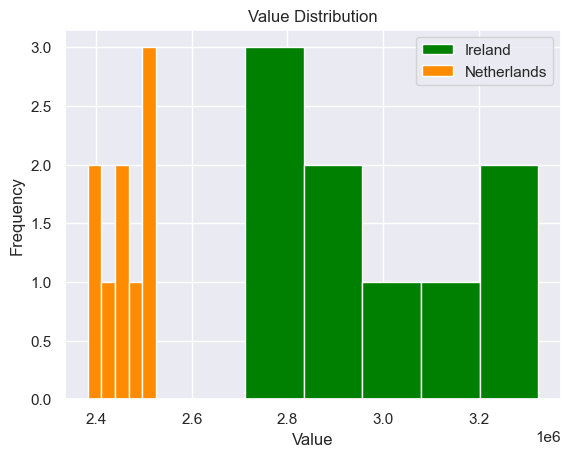

In [38]:
# Filter data for "All ages" age group in both datasets
all_ages = df[df["Age Group"] == "All ages"]
all_ages2 = df2[df2["Age Group"] == "All ages"]
# Create histograms for the 'Value' column in both datasets
plt.hist(all_ages["Value"], bins=5, color="green", label='Ireland')  # Histogram for Ireland
plt.hist(all_ages2["Value"], bins=5, color="darkorange", label='Netherlands')  # Histogram for Netherlands
# Add a legend, title, and axis labels
plt.legend()
plt.title("Value Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
# Display the plot
plt.show()

In [39]:
# Creating the Dropdown widget for selecting the age group
age_group_dropdown_box_plot = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

output_box_plot = widgets.Output()

def update_box_plot(change):
    with output_box_plot:
        clear_output(wait=True)

        selected_age_group = age_group_dropdown_box_plot.value
        # Filtering the combined data for the selected age group
        filtered_df = df[df["Age Group"] == selected_age_group]
        filtered_df2 = df2[df2["Age Group"] == selected_age_group]

        # Creating subplots
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Plotting the boxplot for Ireland on the first subplot
        sns.boxplot(y="Value", data=filtered_df,color="green", ax=axes[0])
        axes[0].set_title(f"Ireland - {selected_age_group}")
        
        # Plotting the boxplot for Netherlands on the second subplot
        sns.boxplot(y="Value", data=filtered_df2,color="darkorange", ax=axes[1])
        axes[1].set_title(f"Netherlands - {selected_age_group}")
        
        # Display the plot
        plt.tight_layout()
        plt.show()

# Reassign the observe function to the new function that plots side by side
#age_group_dropdown_box_plot.unobserve(update_box_plot, names='value')
age_group_dropdown_box_plot.observe(update_box_plot, names='value')

# Displaying the widgets and re-initializing the plot
display(age_group_dropdown_box_plot, output_box_plot)
update_box_plot(None)  # Trigger the initial plot for side by side view


Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

In [40]:
no_all_ages=df[df['Age Group']!="All ages"]
no_all_ages['Age Group'].unique()

array(['17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years',
       '50 - 59 years', '60 - 69 years', '70 years and over',
       'Under 17 years'], dtype=object)

In [41]:
# Function to calculate 'All ages' total for each year
def calculate_all_ages_total(df):
    return df[df["Age Group"]=="All ages"].groupby("Year")["Value"].sum()

ireland_all_ages = calculate_all_ages_total(df)
netherlands_all_ages = calculate_all_ages_total(df2)

# Dropdown widgets
country_dropdown = widgets.Dropdown(options=["Ireland", "Netherlands"], description="Country:")
age_group_dropdown = widgets.Dropdown(options=[ag for ag in df['Age Group'].unique() if ag != "All ages"],
                                      description="Age Group:")
year_dropdown = widgets.Dropdown(options=list(df['Year'].unique()), description='Year:')

# Output area for the pie chart
output_pie_chart = widgets.Output()

# Update function for the pie chart
def update_pie_chart(change):
    with output_pie_chart:
        clear_output(wait=True)
        selected_country = country_dropdown.value
        selected_age_group = age_group_dropdown.value
        selected_year = year_dropdown.value

        # Select the appropriate dataframe and 'All ages' total
        if selected_country == "Ireland":
            data_df = df
            total_all_ages = ireland_all_ages[selected_year]
            colors = ["blue", "green"]
        else:
            data_df = df2
            total_all_ages = netherlands_all_ages[selected_year]
            colors = ["blue", "darkorange"]

        # Filter data for the selected year and age group
        filtered_data = data_df[(data_df["Year"] == selected_year) & (data_df["Age Group"] == selected_age_group)]
        age_group_value = filtered_data["Value"].sum()

        # Values and labels for the pie chart
        values = [age_group_value, total_all_ages - age_group_value]
        labels = [selected_age_group, "All ages"]

        # Plotting the pie chart
        plt.figure(figsize=(8, 8))
        plt.pie(values, labels=labels, colors = colors ,autopct="%1.1f%%", startangle=140)
        plt.title(f"{selected_age_group} vs All Ages in {selected_country} for {selected_year}")
        plt.show()

# Observing changes in the widgets
country_dropdown.observe(update_pie_chart, names="value")
age_group_dropdown.observe(update_pie_chart, names="value")
year_dropdown.observe(update_pie_chart, names="value")

# Display the widgets and output area
display_widgets = widgets.VBox([year_dropdown, country_dropdown, age_group_dropdown, output_pie_chart])
display(display_widgets)

update_pie_chart(None)# Initial plot

In [42]:
# Creating a Dropdown widget for selecting the country
country_dropdown_line_plot = widgets.Dropdown(
    options=["Ireland", "Netherlands"],
    value="Ireland",
    description="Country:",
    disabled=False,
)

# Creating a Dropdown widget for selecting the age group
age_group_dropdown_line_plot = widgets.Dropdown(
    options=list(df["Age Group"].unique()),
    description="Age Group:",
    disabled=False,
)

# Creating an output area to display the plot
output_line_plot = widgets.Output()

# Graphics update function
def update_line_plot(change):
    with output_line_plot:
        clear_output(wait=True)  # Clear the current output
        selected_country = country_dropdown_line_plot.value
        selected_age_group = age_group_dropdown_line_plot.value

        if selected_country == "Ireland":
            data = df
        else:
            data = df2
            
        plt.figure(figsize=(12, 6))
        data_line_plot = data[data["Age Group"] == selected_age_group]
        sns.lineplot(data=data_line_plot, x="Year", y="Value")
        plt.title(f"Trend of {selected_age_group} in {selected_country} (2014-2022)")
        plt.ylabel("Value")
        plt.xlabel("Year")
        plt.show()

# Set up observation for changes in the Dropdown widget to update the plot accordingly
country_dropdown_line_plot.observe(update_line_plot, names="value")
age_group_dropdown_line_plot.observe(update_line_plot, names="value")

# Display the Dropdown widgets and the output area
display(country_dropdown_line_plot, age_group_dropdown_line_plot, output_line_plot)
update_line_plot(None)  # Initial plot


Dropdown(description='Country:', options=('Ireland', 'Netherlands'), value='Ireland')

Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

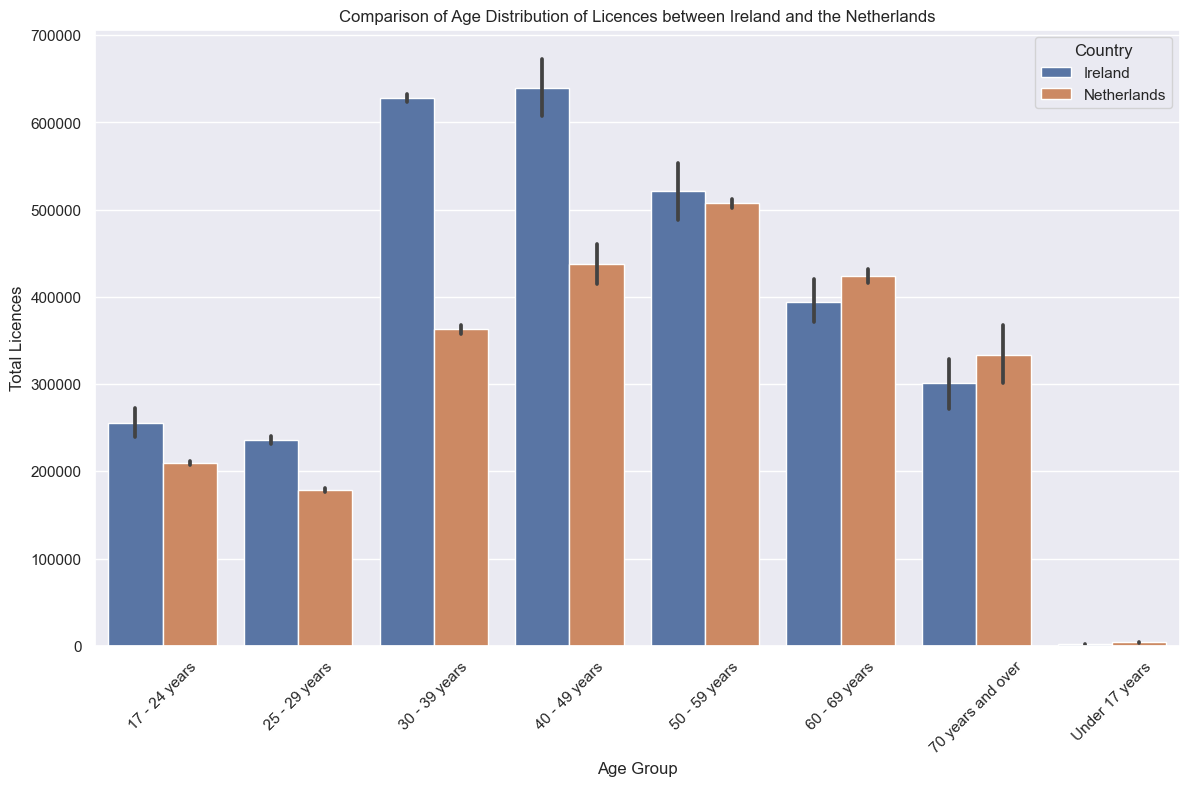

In [43]:
# Comparison of age distributions between Ireland and the Netherlands
# Concatenating the two datasets for comparison, adding a 'Country' column
df_barplot=df[df["Age Group"] != "All ages"]
df2_barplot=df2[df2["Age Group"] != "All ages"]
df_barplot["Country"] = "Ireland"
df2_barplot["Country"] = "Netherlands"
combined_df = pd.concat([df_barplot, df2_barplot])

# Plotting age distribution comparison
plt.figure(figsize=(14, 8))
sns.barplot(data=combined_df, x="Age Group", y="Value", hue="Country")
plt.title("Comparison of Age Distribution of Licences between Ireland and the Netherlands")
plt.ylabel("Total Licences")
plt.xlabel("Age Group")
plt.xticks(rotation=45)
plt.show()


# çıkarımsal istatistik testleri

## 1- Shapiro-Wilk Test for Normality

Hypotheses for Shapiro-Wilk Test:

    1- Null Hypothesis (H0): The distribution of driving license holders for each age group is normally distributed.
    2- Alternative Hypothesis (H1): The distribution of driving license holders for at least one age group is not normally distributed.

These hypotheses will be tested separately for each age group in the Irish and Dutch data sets. The Shapiro-Wilk test determines whether to reject the null hypothesis based on the p-value. If the p-value is less than the specified significance threshold (0.05), then the null hypothesis is rejected and it is concluded that the data are not normally distributed.

In [44]:
from scipy.stats import shapiro

# Shapiro-Wilk Test for normality on the 'Value' column of both datasets
shapiro_test_ireland = shapiro(df[df["Age Group"]!="All ages"]['Value'])
shapiro_test_netherlands = shapiro(df2[df2["Age Group"]!="All ages"]['Value'])
if shapiro_test_ireland.pvalue >= 0.05:
        hypothesis_ireland = "H0"
else: hypothesis_ireland = "H1"
print(hypothesis_ireland,f"Shapiro Result; Statistic: {shapiro_test_ireland.statistic:.4f}",
          f"P-value: {shapiro_test_ireland.pvalue:.6f}","Ireland")
if shapiro_test_netherlands.pvalue >= 0.05:
        hypothesis_netherlands = "H0"
else: hypothesis_netherlands = "H1"
print(hypothesis_netherlands,f"Shapiro Result; Statistic: {shapiro_test_netherlands.statistic:.4f}",
          f"P-value: {shapiro_test_netherlands.pvalue:.6f}","Netherlands")

H1 Shapiro Result; Statistic: 0.9272 P-value: 0.000454 Ireland
H1 Shapiro Result; Statistic: 0.9045 P-value: 0.000047 Netherlands


When the Shapiro-Wilk test was applied to assess the normality of driving license distributions in different age groups, different patterns emerged between Ireland and Zuid-Holland. In Ireland, the 'under 17' and '17-24' age groups showed p-values below the 0.05 threshold (0.0049 and 0.0086 respectively), indicating a non-normal distribution. In contrast, all age groups in Zuid-Holland showed p-values above 0.05, indicating the possibility of a more uniform distribution of license holders across age groups.

In [96]:
# Shapiro-Wilk Test for normality on the 'Value' column of both datasets
age_group = df["Age Group"].unique()
shapiro_results = {
    "Ireland": [],
    "Netherlands": []
}
print("Shapiro-Wilk Test Results For Each Age Group:\n")
for age in age_group: 
    shapiro_test_ireland = shapiro(df[df["Age Group"]==age]['Value'])
    shapiro_results["Ireland"].append((age, shapiro_test_ireland.statistic, shapiro_test_ireland.pvalue))
    shapiro_test_netherlands = shapiro(df2[df2["Age Group"]==age]['Value'])
    shapiro_results["Netherlands"].append((age, shapiro_test_netherlands.statistic, shapiro_test_netherlands.pvalue))
    if shapiro_test_ireland.pvalue  >= 0.05:
        hypothesis_ireland = "H0"
    else: hypothesis_ireland = "H1"
    print(hypothesis_ireland,f"Shapiro; Statistic: {shapiro_test_ireland.statistic:.4f}",
          f"\tP-value: {shapiro_test_ireland.pvalue:.4f}",f"\t{age}","Ireland")
    if shapiro_test_netherlands.pvalue >= 0.05:
        hypothesis_netherlands = "H0"
    else: hypothesis_netherlands = "H1"
    print(hypothesis_netherlands,f"Shapiro; Statistic: {shapiro_test_netherlands.statistic:.4f}",
          f"\tP-value: {shapiro_test_netherlands.pvalue:.4f}",f"\t{age}","Netherlands")

Shapiro-Wilk Test Results For Each Age Group:

H1 Shapiro; Statistic: 0.7672 	P-value: 0.0086 	17 - 24 years Ireland
H0 Shapiro; Statistic: 0.9329 	P-value: 0.5096 	17 - 24 years Netherlands
H0 Shapiro; Statistic: 0.9333 	P-value: 0.5129 	25 - 29 years Ireland
H0 Shapiro; Statistic: 0.9398 	P-value: 0.5803 	25 - 29 years Netherlands
H0 Shapiro; Statistic: 0.9505 	P-value: 0.6955 	30 - 39 years Ireland
H0 Shapiro; Statistic: 0.8720 	P-value: 0.1290 	30 - 39 years Netherlands
H0 Shapiro; Statistic: 0.9452 	P-value: 0.6371 	40 - 49 years Ireland
H0 Shapiro; Statistic: 0.9588 	P-value: 0.7858 	40 - 49 years Netherlands
H0 Shapiro; Statistic: 0.9305 	P-value: 0.4861 	50 - 59 years Ireland
H0 Shapiro; Statistic: 0.8461 	P-value: 0.0675 	50 - 59 years Netherlands
H0 Shapiro; Statistic: 0.9437 	P-value: 0.6208 	60 - 69 years Ireland
H0 Shapiro; Statistic: 0.9743 	P-value: 0.9286 	60 - 69 years Netherlands
H0 Shapiro; Statistic: 0.9528 	P-value: 0.7204 	70 years and over Ireland
H0 Shapiro; Sta

An interactive approach was used to analyze the distribution of driving license holders in Ireland and Zuid-Holland by various age groups using the Shapiro-Wilk normality test. The provided Python code demonstrates a widget-based interactive setup that allows the selection of specific age groups to dynamically generate Shapiro-Wilk test results.

With this interactive analysis tool, we can more easily see the results for the age groups of our choice

In [46]:
# Creating a Dropdown widget
age_group_dropdown_shapiro = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

# Creating an output area to display the plot
output_shapiro = widgets.Output()

# Graph update function
def update_shapiro(change):
    with output_shapiro:
        clear_output(wait=True)  # Clear the current output
        selected_age_group = age_group_dropdown_shapiro.value
        
        data_shapiro_test = df[df["Age Group"] == selected_age_group]
        data_shapiro_test2 = df2[df2["Age Group"] == selected_age_group]
        # Shapiro-Wilk Test for normality on the 'Value' column of both datasets
        shapiro_test_ireland = shapiro(data_shapiro_test['Value'])
        shapiro_test_netherlands = shapiro(data_shapiro_test2['Value'])
        
        if shapiro_test_ireland.pvalue  >= 0.05:
            hypothesis_ireland = "H0 (normal distribution)"
        else: hypothesis_ireland = "H1 (non normal distribution)"
        if shapiro_test_netherlands.pvalue >= 0.05:
            hypothesis_netherlands = "H0 (normal distribution)"
        else: hypothesis_netherlands = "H1 (non normal distribution)"
        
        print(f"Selected age group= {selected_age_group}\n")
        print(f"Ireland Hypothsis Result: {hypothesis_ireland}")
        print(f"Ireland {shapiro_test_ireland}\n")
        print(f"Netherlands Hypothsis Result: {hypothesis_netherlands}")
        print(f"Netherlands {shapiro_test_netherlands}")

# Set up observation for changes in the Dropdown widget to update the plot accordingly
age_group_dropdown_shapiro.observe(update_shapiro, names='value')

# Display the Dropdown widgets and the output area
display(age_group_dropdown_shapiro, output_shapiro)
update_shapiro(None)  # Initial plot

Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

The results of the Shapiro-Wilk test for driving license distributions are visualized across age groups for Ireland and Zuid-Holland.
The scatter plot visualizes the p-values for each age group and draws a clear boundary at the threshold p = 0.05, which serves as a line between normal and non-normal distributions. For Ireland, the age groups '17 - 24 years' and 'under 17' show p-values below this threshold, indicating non-normality, while for Zuid-Holland all age groups appear above the line, indicating a normal distribution of licensees. 


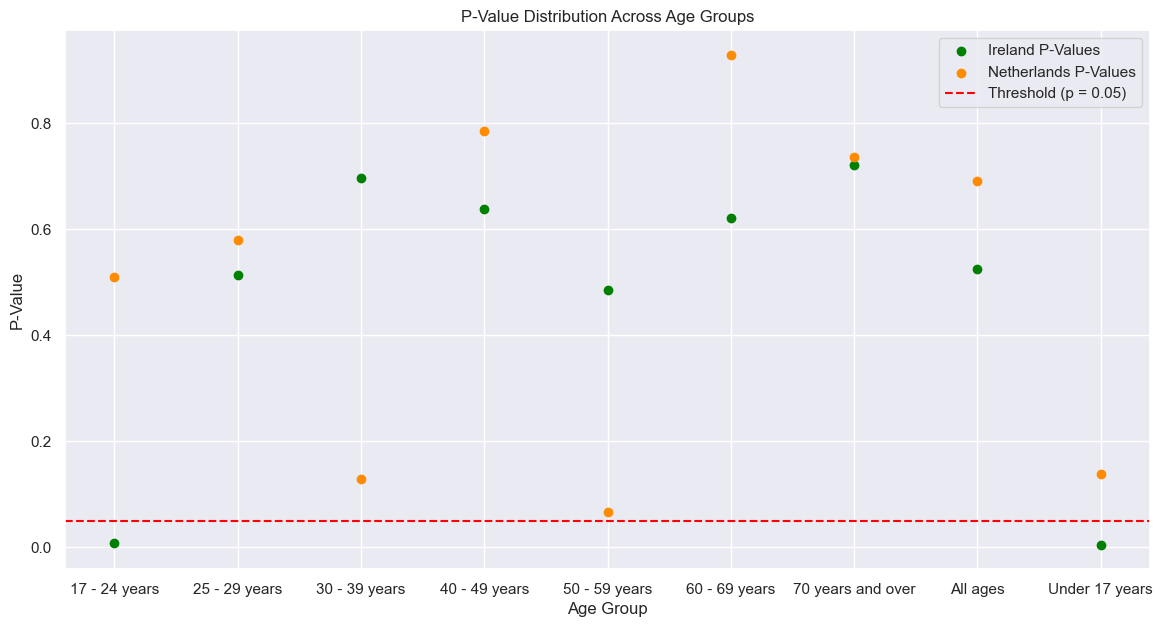

In [47]:
import pandas as pd
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.pyplot as plt


# Create empty lists to store Shapiro-Wilk test resultsshapiro_results = {
    "Ireland": [],
    "Netherlands": []
}
age_groups=df['Age Group'].unique()
# Let's do Shapiro-Wilk test for each age group
for age in age_groups:
    # For Ireland data
    shapiro_test_ireland = shapiro(df[df["Age Group"] == age]['Value'])
    shapiro_results["Ireland"].append((age, shapiro_test_ireland.statistic, shapiro_test_ireland.pvalue))
    
    # For Netherlands data
    shapiro_test_netherlands = shapiro(df2[df2["Age Group"] == age]['Value'])
    shapiro_results["Netherlands"].append((age, shapiro_test_netherlands.statistic, shapiro_test_netherlands.pvalue))

# P-Value Scatter Plot
plt.figure(figsize=(14, 7))
for country, color in zip(shapiro_results, ['green', 'darkorange']):
    ages, _, p_values = zip(*shapiro_results[country])
    plt.scatter(ages, p_values, color=color, label=f'{country} P-Values')
plt.axhline(0.05, color='red', linestyle='--', label='Threshold (p = 0.05)')
plt.xlabel('Age Group')
plt.ylabel('P-Value')
plt.title('P-Value Distribution Across Age Groups')
plt.legend()
plt.show()

In the visual output, histograms for the '30 - 39 years' age group in Ireland and the '60 - 69 years' age group in the Netherlands are displayed. The histograms indicate the count of license values within specified ranges, overlaid with a kernel density estimate that provides a smooth estimate of the distribution. 

In [48]:
# Creating a Dropdown widget
country_dropdown_dist_value = widgets.Dropdown(
    options=['Ireland', 'Netherlands'],
    value='Ireland',
    description='Country:',
    disabled=False,
)

age_group_dropdown_dist_value = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

# Creating an output area to display the plot
output_dist_value= widgets.Output()

# Graph update function
def update_dist_value(change):
    with output_dist_value:
        clear_output(wait=True)  # Clear the current output
        selected_country = country_dropdown_dist_value.value
        selected_age_group = age_group_dropdown_dist_value.value

        if selected_country == 'Ireland':
            data = df
        else:
            data = df2

        data_dist_value = data[data['Age Group'] == selected_age_group]
        sns.histplot(data_dist_value["Value"], kde=True, bins=9)
        plt.title(f"Distribution of Licence Values for {selected_age_group} Age Group in the {selected_country}")
        plt.xticks(rotation=90)
        plt.show()
        
# Set up observation for changes in the Dropdown widget to update the plot accordingly
country_dropdown_dist_value.observe(update_dist_value, names='value')
age_group_dropdown_dist_value.observe(update_dist_value, names='value')

# Display the Dropdown widgets and the output area
display(country_dropdown_dist_value, age_group_dropdown_dist_value, output_dist_value)
update_dist_value(None)  # Initial plot

Dropdown(description='Country:', options=('Ireland', 'Netherlands'), value='Ireland')

Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

Providing Python code, I created an interactive tool using ipywidgets to generate Q-Q (Quantile-Quantile) plots for different age groups in the Irish and Zuid-Holland datasets. These plots show whether the distribution of driving license values follows a normal distribution, an important assumption in many statistical tests.

In [49]:
# Additionally, plotting a Q-Q plot to visually assess the normality
import scipy.stats as stats


# Creating a Dropdown widget
country_dropdown_qq_plot = widgets.Dropdown(
    options=['Ireland', 'Netherlands'],
    value='Ireland',
    description='Country:',
    disabled=False,
)

age_group_dropdown_qq_plot = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

# Creating an output area to display the plot
output_qq_plot = widgets.Output()

# Graph update function
def update_qq_plot(change):
    with output_qq_plot:
        clear_output(wait=True)   # Clear the current output
        selected_country = country_dropdown_qq_plot.value
        selected_age_group = age_group_dropdown_qq_plot.value

        if selected_country == 'Ireland':
            data = df
        else:
            data = df2

        data_qq_plot = data[data['Age Group'] == selected_age_group]
        stats.probplot(data_qq_plot['Value'], dist="norm", plot=plt)
        plt.title(f"Q-Q Plot for {selected_age_group} Age Group in the {selected_country}")
        plt.show()
# Set up observation for changes in the Dropdown widget to update the plot accordingly
country_dropdown_qq_plot.observe(update_qq_plot, names='value')
age_group_dropdown_qq_plot.observe(update_qq_plot, names='value')

# Display the Dropdown widgets and the output area
display(country_dropdown_qq_plot, age_group_dropdown_qq_plot, output_qq_plot)
update_qq_plot(None)  # Initial plot

Dropdown(description='Country:', options=('Ireland', 'Netherlands'), value='Ireland')

Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

## 2. Welch's T-Test

A Welch's T-test was conducted to assess whether there is a statistically significant difference in the average number of driving licenses held between Ireland and the Netherlands.
### Hypotheses for T-Test:
    Null Hipotezi (H0): There is no statistically significant difference between the means of the two groups.
    Alternatif Hipotezi (H1): There is a statistically significant difference between the means of the two groups.

In [98]:
from scipy.stats import ttest_ind

# Performing Welch's T-test (which does not assume equal variances) between Ireland and Netherlands for the year 2014
ttest_result = ttest_ind(df[df["Age Group"]!="All ages"]['Value'],
                          df2[df2["Age Group"]!="All ages"]['Value'], equal_var=False)
if ttest_result.pvalue  >= 0.05:
    hypothesis_ttest = "H0 (There is no statistically significant difference between the means of the two groups.)"
else: hypothesis_ttest = "H1 (There is a statistically significant difference between the means of the two groups.)"
ttest_result
print(f"Hypothsis Result: {hypothesis_ttest}\n")
print(f"T-test Result;\nStatistic:{ttest_result.statistic:.5f}",
      f"\nPvalue:\t{ttest_result.pvalue:.5f}\ndf:\t{ttest_result.df:5f}\n")

Hypothsis Result: H1 (There is a statistically significant difference between the means of the two groups.)

T-test Result;
Statistic:2.10303 
Pvalue:	0.03736
df:	132.259532



In [51]:
# Creating a Dropdown widget
age_group_dropdown_ttest = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

# Creating an output area to display the plot
output_ttest = widgets.Output()

# Graph update function
def update_ttest(change):
    with output_ttest:
        clear_output(wait=True)  # Clear the current output
        selected_age_group = age_group_dropdown_ttest.value
        
        # Performing T-test between Ireland and Netherlands for the spesific age group
        ttest_result = ttest_ind(df[df["Age Group"]==selected_age_group]['Value'],
                          df2[df2["Age Group"]==selected_age_group]['Value'], equal_var=False)
        
        if ttest_result.pvalue  >= 0.05:
            hypothesis_ttest = "H0 (There is no statistically significant difference between the means of the two groups.)"
        else: hypothesis_ttest= "H1 (There is a statistically significant difference between the means of the two groups.)"
        
        print(f"Selected age group= {selected_age_group}\n")
        print(f"Hypothsis Result: {hypothesis_ttest}\n")
        print(f"T-test Result;\nStatistic:{ttest_result.statistic:.5f}\n",
              f"Pvalue:\t{ttest_result.pvalue:.5f}\ndf:\t{ttest_result.df:5f}\n")

# Set up observation for changes in the Dropdown widget to update the plot accordingly
age_group_dropdown_ttest.observe(update_ttest, names='value')

# Display the Dropdown widgets and the output area
display(age_group_dropdown_ttest, output_ttest)
update_ttest(None)  # Initial plot

Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

## 3. ANOVA (Analysis of Variance) (Parametric)

ANOVA is a parametric test used in statistics to compare the means of three or more samples to understand if at least one sample mean is significantly different from the others.
### Hypotheses for ANOVA:
- Null Hypothesis (H0): All age groups have the same mean number of driving licenses.
- Alternative Hypothesis (H1): At least one age group has a different mean number of driving licenses.

As a result of the ANOVA, the F-statistic is approximately 4.4228 and measures the ratio of the variance between group means to the variance within groups. P-value of 0.0372 is less than the alpha threshold of 0.05, the null hypothesis can be rejected. This means that there is a statistically significant difference between group means, indicating that not all population means are equal. In the context of driving license data, this could mean that the average number of driving licenses differs between age groups or between the compared countries.
It is important to note that although ANOVA tells us that at least one group mean is different, it does not specify which groups are different from each other.


In [52]:
from scipy.stats import f_oneway
# Prepare the data for ANOVA
anova_results = {}
df_f_oneway=df[df["Age Group"] != "All ages"]["Value"]
df2_f_oneway=df2[df2["Age Group"] != "All ages"]["Value"]
f_stat, p_value = f_oneway(df_f_oneway, df2_f_oneway)
anova_results = {'F-Statistic': f_stat, 'p-value': p_value}
print(f"F-Statistic: {f_stat:.4f}",f"\tP-Value: {p_value:.4f}")

F-Statistic: 4.4228 	P-Value: 0.0372


In [53]:
# Prepare the data for ANOVA
anova_results = {}
#age_groups = df["Age Group"].unique()

for age_group in age_groups:
    # Get the values for Ireland and Netherlands for this age group
    ireland_values = df[df["Age Group"] == age_group]["Value"]
    netherlands_values = df2[df2["Age Group"] == age_group]["Value"]
    
    # Perform ANOVA (Analysis of Variance) test
    f_stat, p_value = f_oneway(ireland_values, netherlands_values)
    anova_results[age_group] = {'F-Statistic': f_stat, 'p-value': p_value}
    print(f"F-Statistic {f_stat:.4f}",f"\tP-Value {p_value:.4f}",f"\t\t{age_group}")


F-Statistic 22.0162 	P-Value 0.0002 		17 - 24 years
F-Statistic 428.5690 	P-Value 0.0000 		25 - 29 years
F-Statistic 5084.0063 	P-Value 0.0000 		30 - 39 years
F-Statistic 86.0949 	P-Value 0.0000 		40 - 49 years
F-Statistic 0.6134 	P-Value 0.4449 		50 - 59 years
F-Statistic 4.4470 	P-Value 0.0511 		60 - 69 years
F-Statistic 1.7742 	P-Value 0.2015 		70 years and over
F-Statistic 48.7577 	P-Value 0.0000 		All ages
F-Statistic 48.6462 	P-Value 0.0000 		Under 17 years


## 4. Mann-Whitney U Test

The Mann-Whitney U test is a non-parametric test used to compare differences between two independent groups when the dependent variable is either ordinal or continuous, but not normally distributed. It assesses whether there is a statistically significant difference in the distribution of two independent groups.

### Hypotheses for Mann-Whitney U:
- Null Hypothesis (H0): The distributions of the number of driving licenses are the same between the two countries.
- Alternative Hypothesis (H1): There is a difference in the distributions of the number of driving licenses between the two countries.

In [54]:
from scipy.stats import mannwhitneyu

# Selecting the data for the year 2014 from both datasets
ireland_2014 = df[df["Year"] == 2014]["Value"]
netherlands_2014 = df2[df2["Year"] == 2014]["Value"]

# Performing Mann-Whitney U Test between Ireland and Netherlands for the year 2014
mannwhitney_test_2014 = mannwhitneyu(ireland_2014, netherlands_2014)

mannwhitney_test_2014


MannwhitneyuResult(statistic=44.0, pvalue=0.7910815129207817)

In [55]:
from scipy.stats import mannwhitneyu
years=df["Year"].unique()
# Performing Mann-Whitney U Test between Ireland and Netherlands for the years
for year in years:
    ireland_years = df[df["Year"] == year]["Value"]
    netherlands_years = df2[df2["Year"] == year]["Value"]
    mannwhitney_test_years = mannwhitneyu(ireland_years, netherlands_years)
    print(year,"=",mannwhitney_test_years)

2014 = MannwhitneyuResult(statistic=44.0, pvalue=0.7910815129207817)
2015 = MannwhitneyuResult(statistic=44.0, pvalue=0.7910815129207817)
2016 = MannwhitneyuResult(statistic=46.0, pvalue=0.6588432549492806)
2017 = MannwhitneyuResult(statistic=46.0, pvalue=0.6588432549492806)
2018 = MannwhitneyuResult(statistic=46.0, pvalue=0.6588432549492806)
2019 = MannwhitneyuResult(statistic=47.0, pvalue=0.5962416305866567)
2020 = MannwhitneyuResult(statistic=48.0, pvalue=0.5364994693194564)
2021 = MannwhitneyuResult(statistic=49.0, pvalue=0.47992869214595724)
2022 = MannwhitneyuResult(statistic=50.0, pvalue=0.42677673653298365)


In [56]:
from scipy.stats import mannwhitneyu
years=df["Year"].unique()
# Performing Mann-Whitney U Test between Ireland and Netherlands for the years 
df_no_all_ages = df[df["Age Group"] != "All ages"]
df2_no_all_ages = df2[df2["Age Group"] != "All ages"]

for year in years:
    ireland_years = df_no_all_ages[df_no_all_ages["Year"] == year]["Value"]
    netherlands_years = df2_no_all_ages[df2_no_all_ages["Year"] == year]["Value"]
    mannwhitney_test_years = mannwhitneyu(ireland_years, netherlands_years)
    print(year,"=",mannwhitney_test_years)

2014 = MannwhitneyuResult(statistic=35.0, pvalue=0.7984459984459983)
2015 = MannwhitneyuResult(statistic=35.0, pvalue=0.7984459984459983)
2016 = MannwhitneyuResult(statistic=37.0, pvalue=0.6453768453768453)
2017 = MannwhitneyuResult(statistic=37.0, pvalue=0.6453768453768453)
2018 = MannwhitneyuResult(statistic=37.0, pvalue=0.6453768453768453)
2019 = MannwhitneyuResult(statistic=38.0, pvalue=0.5737373737373737)
2020 = MannwhitneyuResult(statistic=39.0, pvalue=0.5053613053613053)
2021 = MannwhitneyuResult(statistic=40.0, pvalue=0.4418026418026417)
2022 = MannwhitneyuResult(statistic=41.0, pvalue=0.3822843822843822)


The first test compares all datasets on driving license numbers between Ireland and the Netherlands, and the second test compares the datasets with the "All ages" category removed.

Mann-Whitney U Test on All Data Sets: Mann-Whitney Statistic: 3813.0 P-value: 0.0747 Since the P-value is greater than the traditional alpha level of 0.05, the result indicates a statistically significant difference in driving distributions. shows that there is no difference. License numbers between the two countries considering the entire data sets.

In [57]:
# Performing Mann-Whitney U Test on the entire datasets for 'Value' column
mannwhitney_test_result = mannwhitneyu(df['Value'], df2['Value'])
print("Results with whole data set")
print(f"mannwhitney Statistic Result= {mannwhitney_test_result.statistic}")
print(f"mannwhitney p-value Result= {round(mannwhitney_test_result.pvalue,4)}")

Results with whole data set
mannwhitney Statistic Result= 3813.0
mannwhitney p-value Result= 0.0747


Mann-Whitney U Test Removed from "All Ages": Mann-Whitney Statistic: 3084.0 P value: 0.0496 The fact that the p value after removing the "all ages" category is approximately 0.0496, just below the 0.05 threshold, suggests that there may be a statistically significant difference in the distribution of driver's license numbers between the two countries when this category is excluded.

In [58]:
# Performing Mann-Whitney U Test on the entire datasets for 'Value' column

df_no_all_ages = df[df["Age Group"] != "All ages"]
df2_no_all_ages = df2[df2["Age Group"] != "All ages"]

mannwhitney_test_result_no_all_ages = mannwhitneyu(df_no_all_ages["Value"], df2_no_all_ages["Value"])
print("Results with 'All ages' age group removed from the data set")
print(f"mannwhitney Statistic Result= {mannwhitney_test_result_no_all_ages.statistic}")
print(f"mannwhitney p-value Result= {round(mannwhitney_test_result_no_all_ages.pvalue,4)}")

Results with 'All ages' age group removed from the data set
mannwhitney Statistic Result= 3084.0
mannwhitney p-value Result= 0.0496


In order to compare the distribution of driver's license holders between two data sets representing Ireland and the Netherlands, I created a widget to easily access the results of the Mann-Whitney U Test for two different age groups.

In [59]:
# Creating a Dropdown widget 
age_group_dropdown_mannwhitney = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

# Creating an output area to display the plot
output_mannwhitney = widgets.Output()

# Graph update function
def update_mannwhitney(change):
    with output_mannwhitney:
        clear_output(wait=True)  # Clear the current output
        selected_age_group = age_group_dropdown_mannwhitney.value

        data_mannwhitney = df[df["Age Group"] == selected_age_group]
        data_mannwhitney2 = df2[df2["Age Group"] == selected_age_group]
        mannwhitney_test_result= mannwhitneyu(data_mannwhitney['Value'], data_mannwhitney2['Value'])
        print(f"Selected age group= {selected_age_group}\n")
        print(f"mannwhitney Statistic Result= {mannwhitney_test_result.statistic}")
        print(f"mannwhitney p-value Result= {round(mannwhitney_test_result.pvalue,5)}")
# Set up observation for changes in the Dropdown widget to update the plot accordingly
age_group_dropdown_mannwhitney.observe(update_mannwhitney, names='value')

# Display the Dropdown widgets and the output area
display(age_group_dropdown_mannwhitney, output_mannwhitney)
update_mannwhitney(None)  # Initial plot

Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

## 5. Kruskal-Wallis H Test

The Kruskal-Wallis H test is a nonparametric method to test whether samples come from the same distribution. It is used to compare more than two samples that are independent or unrelated to each other. The hypothesis tested is whether the means of the groups differ, without assuming that the sample data have a normal distribution.

### Hypotheses for Kruskal-Wallis H 
- Null Hypothesis (H0): All groups come from the same distribution.
- Alternative Hypothesis (H1): There is a statistically significant difference among the distributions of different groups.

In [60]:
from scipy.stats import kruskal

# Extracting values for different age groups in Ireland for the year 2014
age_groups = df['Age Group'].unique()
values_by_age_group = [df[(df['Year'] == 2014) & (df['Age Group'] == age)].Value for age in age_groups]

# Performing Kruskal-Wallis H Test among different age groups in Ireland for the year 2014
kruskal_test = kruskal(*values_by_age_group)

kruskal_test

KruskalResult(statistic=8.0, pvalue=0.43347012036670896)

In [61]:
# Extracting the age groups
age_groups = df['Age Group'].unique()

# Preparing an empty list to store the values of each group
values_by_age_group = []

# Extracting values for each age group from both datasets
for age_group in age_groups:
    if age_group != 'All ages':  # Excluding the 'All ages' group
        ireland_values = df[df['Age Group'] == age_group]['Value']
        netherlands_values = df2[df2['Age Group'] == age_group]['Value']
        
        # Appending the values to the list
        values_by_age_group.extend([ireland_values, netherlands_values])
# Performing Kruskal-Wallis H Test across all age groups and countries
kruskal_test_result = kruskal(*values_by_age_group)

kruskal_test_result

KruskalResult(statistic=138.63665389527466, pvalue=4.274481956243129e-22)

In [62]:
from scipy.stats import kruskal

# Filtering out 'All ages' group from both datasets
df_filtered = df[df['Age Group'] != 'All ages']
df2_filtered = df2[df2['Age Group'] != 'All ages']

# Preparing the data for Kruskal-Wallis H Test
# Extracting the age groups
age_groups = df_filtered['Age Group'].unique()

# Re-performing Kruskal-Wallis H Test across all age groups for both countries
kruskal_test_results = {}

for age_group in age_groups:
    ireland_values = df_filtered[df_filtered['Age Group'] == age_group]['Value']
    netherlands_values = df2_filtered[df2_filtered['Age Group'] == age_group]['Value']

    # Perform Kruskal-Wallis H test for this age group
    H_stat, p_value = kruskal(ireland_values, netherlands_values)
    kruskal_test_results[age_group] = {'H_stat': round(H_stat,4), 'p_value': round(p_value,4)}

kruskal_test_results


{'17 - 24 years': {'H_stat': 12.7895, 'p_value': 0.0003},
 '25 - 29 years': {'H_stat': 12.7895, 'p_value': 0.0003},
 '30 - 39 years': {'H_stat': 12.7895, 'p_value': 0.0003},
 '40 - 49 years': {'H_stat': 12.7895, 'p_value': 0.0003},
 '50 - 59 years': {'H_stat': 0.0019, 'p_value': 0.9648},
 '60 - 69 years': {'H_stat': 2.1228, 'p_value': 0.1451},
 '70 years and over': {'H_stat': 1.6394, 'p_value': 0.2004},
 'Under 17 years': {'H_stat': 11.5575, 'p_value': 0.0007}}

# Machine Learning

## Random Forest Regressor

In [64]:
# Importing necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# copy the dataset
df_RFR = df.copy()

# Encode the 'Age Group' categorical data to numeric
label_encoder = LabelEncoder()
df_RFR["Age Group Encoded"] = label_encoder.fit_transform(df_RFR["Age Group"])

# Selecting features and target variable
X = df_RFR[["Year", "Age Group Encoded"]]  # Features
y = df_RFR["Value"]  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"{df.head}\n")
print("X_train:\n",f"{X_train.head()}\n")
print("y_train:\n",f"{y_train.head()}\n")

<bound method NDFrame.head of     Year          Age Group    Value
0   2014      17 - 24 years   237524
1   2014      25 - 29 years   245595
2   2014      30 - 39 years   629313
3   2014      40 - 49 years   568308
4   2014      50 - 59 years   454946
..   ...                ...      ...
76  2022      50 - 59 years   601477
77  2022      60 - 69 years   452487
78  2022  70 years and over   367798
79  2022           All ages  3325487
80  2022     Under 17 years     2243

[81 rows x 3 columns]>

X_train:
     Year  Age Group Encoded
61  2020                  7
55  2020                  1
40  2018                  4
9   2015                  0
64  2021                  1

y_train:
 61    3089212
55     227585
40     508060
9      238607
64     238710
Name: Value, dtype: int32



In [65]:
# Defining the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Defining the parameter grid
param_grid = {
    "n_estimators": [50, 70, 100, 200],  # Number of trees in the forest
    "max_depth": [None, 20, 30, 40],     # Maximum depth of the trees
    "min_samples_split": [2, 4, 5, 6]   # Minimum number of samples required to split an internal node
}

print(f"Parameter Grid:\n{param_grid}\n") # Printing the parameter grid

Parameter Grid:
{'n_estimators': [50, 70, 100, 200], 'max_depth': [None, 20, 30, 40], 'min_samples_split': [2, 4, 5, 6]}



In [66]:
# Create GridSearchCV object with the Random Forest Regressor and the defined parameter grid
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

# Fit the GridSearchCV object to the training data to find the best parameters
grid_search_rf.fit(X_train, y_train)

# Extract the best parameters from GridSearchCV
best_params_rf = grid_search_rf.best_params_
best_params_rf

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

"RMSE, Root Mean Square Error, is a measure of how much the predictions of a model deviate from the actual values. Typically, a lower RMSE value indicates better model performance.

R-squared (R²), on the other hand, is an indicator of how much variance in the dependent variable is explained by the independent variables. It takes values between 0 and 1, with a higher R² indicating that the model explains the data better.

In [67]:
# Extract the best parameters from GridSearchCV
best_params_rf = grid_search_rf.best_params_

# Create a new Random Forest Regressor with the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=best_params_rf["n_estimators"],
    max_depth=best_params_rf["max_depth"],
    min_samples_split=best_params_rf["min_samples_split"],
    random_state=42
)

# Fit the model with the best parameters to the training data
best_rf_model.fit(X_train, y_train)

# Predict the values for the test set
y_pred_rf = best_rf_model.predict(X_test)

# Calculate the performance metrics for the Random Forest model
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

rmse_rf, r2_rf


(33727.58129332596, 0.9976727405573973)

In [68]:
# Creating a DataFrame for the predicted values
predicted_df_RFR = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_rf})

# Resetting the index of the DataFrame
predicted_df_RFR.reset_index(drop=True, inplace=True)

# Displaying the first few rows of the DataFrame
predicted_df_RFR.head()

,Actual,Predicted
0,613128,617778.635
1,237524,241425.880
2,479959,490892.700
3,491487,507929.475
4,239640,237263.480


In [69]:
# Creating a Dropdown widget for selecting the year
year_dropdown_RFR = widgets.Dropdown(
    options=df["Year"].unique(),
    description="Year:",
    disabled=False,
)

# Creating an output area to display the plot
output_RFR = widgets.Output()

# Function to update the plot
def update_RFR(change):
    with output_RFR:
        clear_output(wait=True)  # Clear the current output
        selected_year_RFR = year_dropdown_RFR.value
        # We assume that "Age Group Encoded" ranges from 0 to the max value seen in the training set
        age_groups_encoded = np.arange(df_RFR["Age Group Encoded"].max() + 1)
        year_predict = np.full(shape=age_groups_encoded.shape, fill_value=selected_year_RFR)
        
        # Create a new DataFrame for the selected year predictions
        predict_df = pd.DataFrame({
            "Year": year_predict,
            "Age Group Encoded": age_groups_encoded
        })

        # Use the best Random Forest model to predict the 'Value' for each age group in selected_year_RFR
        predicted_values = best_rf_model.predict(predict_df)

        # Use the last known value for each age group as a placeholder for the true value.
        true_values = df[df["Year"] == selected_year_RFR]["Value"].values

        # Add the predictions to the DataFrame
        predict_df["Predicted Value"] = predicted_values.astype(int)

        # Compute error (absolute difference) between the true and predicted values
        predict_df["True Value"] = true_values
        predict_df["Error"] = (abs(predict_df["Predicted Value"] - predict_df["True Value"])).astype(int)
        predict_df["Error Percentage"] = ((predict_df["Error"] / predict_df["True Value"]) * 100).round(2)
        predict_df["Age Group"] = label_encoder.inverse_transform(predict_df["Age Group Encoded"])
        
        # Display the table
        prediction_table = predict_df[["Year", "Age Group", "True Value", "Predicted Value", "Error","Error Percentage"]]

        # Returning the prediction table
        display(prediction_table)

# Observing changes in the Dropdown widgets to update the plot
year_dropdown_RFR.observe(update_RFR, names="value")

# Display the Dropdown widgets and the output area
display(year_dropdown_RFR, output_RFR)
update_RFR(None)  # Initial plot


Dropdown(description='Year:', options=(2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022), value=2014)

Output()

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# We assume that 'Age Group Encoded' ranges from 0 to the max value seen in the training set
age_groups_encoded = np.arange(df_RFR["Age Group Encoded"].max() + 1)
year_2022 = np.full(shape=age_groups_encoded.shape, fill_value=2022)

# Create a new DataFrame for the year 2022 predictions
predict_df = pd.DataFrame({
    "Year": year_2022,
    "Age Group Encoded": age_groups_encoded
})

# Use the best Random Forest model to predict the 'Value' for each age group in 2022
predicted_values_2022 = best_rf_model.predict(predict_df)

# Here, we'll use the last known value for each age group as a placeholder for the true value.
# Compute error (absolute difference) between the true and predicted values
# Add the predictions to the DataFrame
predict_df["Predicted Value"] = predicted_values_2022.astype(int)
true_values_2022 = df[df["Year"] == 2022]["Value"].values
predict_df["True Value"] = true_values_2022
predict_df["Error"] = abs(predict_df["Predicted Value"] - predict_df["True Value"]).astype(int)

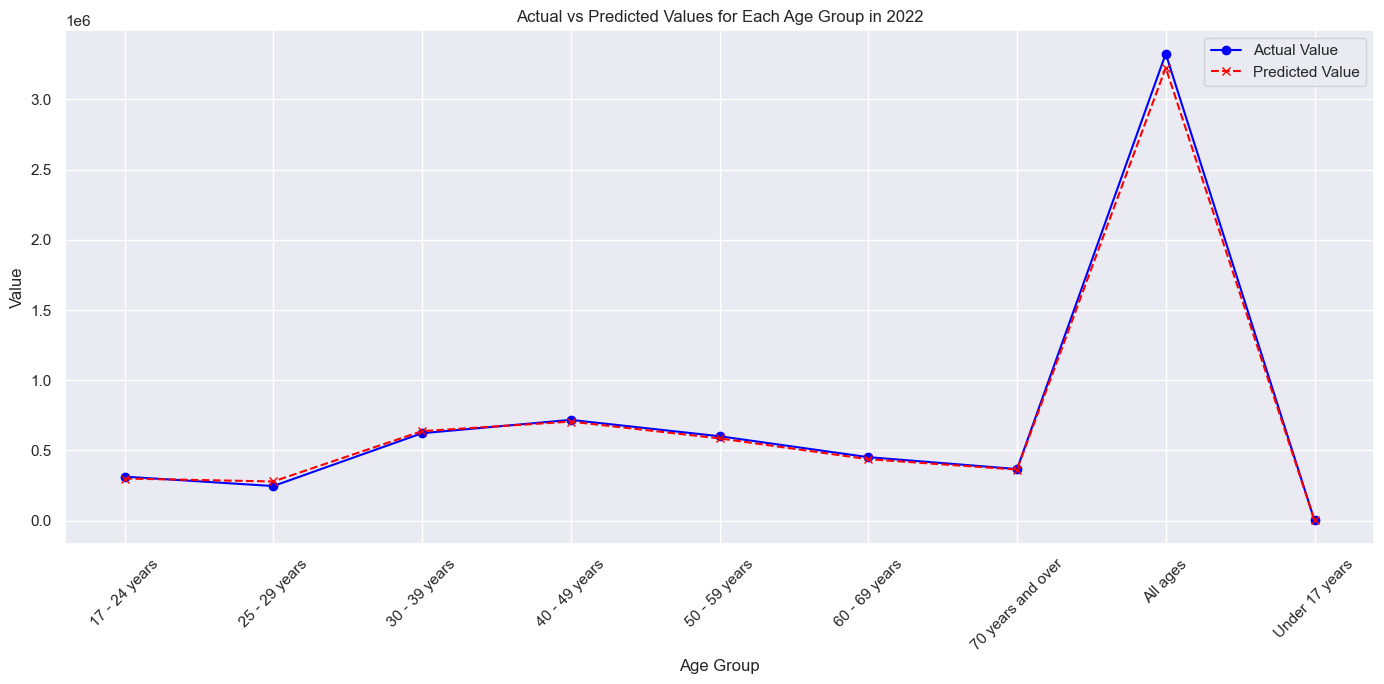

In [71]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(age_groups_encoded, true_values_2022, label="Actual Value", color="blue", marker="o")
plt.plot(age_groups_encoded, predicted_values_2022, label="Predicted Value", color="red", linestyle="--", marker="x")
plt.title("Actual vs Predicted Values for Each Age Group in 2022")
plt.xlabel("Age Group")
plt.ylabel("Value")
plt.xticks(ticks=age_groups_encoded, labels=label_encoder.inverse_transform(age_groups_encoded), rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


In [72]:
# Creating a Dropdown widget 
dropdown_RFR_age = widgets.Dropdown(
    options=df_RFR["Age Group"].unique(),
    description="Year:",
    disabled=False,
)
# Creating an output area to display the plot
output_RFR_age = widgets.Output()
def update_RFR_age(change):
    with output_RFR_age:
        clear_output(wait=True)  # Clear the current output
        selected_RFR_age = dropdown_RFR_age.value
        
        # Encode the selected age group using the label encoder
        selected_age_group_encoded = label_encoder.transform([selected_RFR_age])[0]
        years_RFR_age = df_RFR["Year"].unique()

        # Reconstruct the "all_predictions" DataFrame for the selected age group across all years
        all_predictions_df_RFR_age = []
        for year in years_RFR_age:
            year_array = np.full(shape=(1,), fill_value=year)
            age_group_encoded = label_encoder.transform([selected_RFR_age])
            predict_df_RFR_age = pd.DataFrame({
                "Year": year_array,
                "Age Group Encoded": age_group_encoded
            })
            predicted_value_RFR_age = best_rf_model.predict(predict_df_RFR_age)
            true_value = df_RFR[(df_RFR["Year"] == year) & 
                                      (df_RFR["Age Group Encoded"] == selected_age_group_encoded)]["Value"].values
            # Use the predicted value if no actual value is present for that year
            true_value = true_value[0] if true_value.size > 0 else predicted_value_RFR_age[0]
            all_predictions_df_RFR_age.append((year, true_value, predicted_value_RFR_age[0]))

        # Create a DataFrame from the predictions to facilitate plotting
        predictions_df_RFR_age = pd.DataFrame(all_predictions_df_RFR_age,
                                              columns=['Year', 'Actual Value', 'Predicted Value RFR'])

        # Plot a bar chart comparing the actual and predicted values
        plt.figure(figsize=(14, 7))
        width = 0.35  # Bar width
        plt.bar(predictions_df_RFR_age["Year"] - width/2, predictions_df_RFR_age["Actual Value"], width,
                label="Actual Values", color="blue")
        plt.bar(predictions_df_RFR_age["Year"] + width/2, predictions_df_RFR_age["Predicted Value RFR"],
                width, label="Predicted Values RFR", color="red")

        plt.title(f"Actual vs Predicted Population Values for {selected_RFR_age} Over the Years")
        plt.xlabel("Year")
        plt.ylabel("Population Value RFR")
        plt.xticks(predictions_df_RFR_age["Year"], rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Set up observation for changes in the Dropdown widget to update the plot accordingly
dropdown_RFR_age.observe(update_RFR_age, names="value")

# Display the Dropdown widgets and the output area
display(dropdown_RFR_age, output_RFR_age)
update_RFR_age(None)  # Initial plot

Dropdown(description='Year:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years', '50…

Output()

The graph comparing actual and predicted values for each age group in 2022 shows that the model's predictions closely align with the actual data for most age groups. This suggests that the model has learned the distribution well and is able to generalize from the training data to make accurate predictions. However, there is a significant deviation in the prediction for the 'All ages' category. This deviation indicates a potential area for improvement, which could involve examining the features that contribute to this prediction and considering any data anomalies or external factors that might affect the model's performance.

For a detailed analysis, it would be important to consider factors such as changes in population demographics, policy changes affecting licensing, and economic factors that could influence the number of license holders. These factors could provide insights into why certain predictions may not align with actual values and could inform further model refinement.

Overall, the Random Forest model appears to have performed well, with high accuracy for most age groups. To build on this analysis, further steps could include performing cross-validation to assess the model's stability, checking feature importance to understand the drivers of the model's predictions, and exploring model explainability tools to gain deeper insights into how the model is making its decisions. These additional analyses would provide a more comprehensive understanding of the model's performance and areas for improvement.

## Gradient Boosting Regression

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Convert categorical data to a numerical format
label_encoder = LabelEncoder()
df_GBR = df.copy()
df_GBR["Age Group Encoded"] = label_encoder.fit_transform(df_GBR["Age Group"])

# Separate features and target variable
X = df_GBR[["Year", "Age Group Encoded"]]  # The features include the year and the encoded age group
y = df_GBR["Value"]  # The target variable is the 'Value' column which we want to predict

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 80% of the data will be used for training and 20% for testing

# Check the dimensions of the training and test sets
X_train_shape, X_test_shape = X_train.shape, X_test.shape
# This will show us the number of samples and features in the training and test sets

X_train_shape, X_test_shape


((64, 2), (17, 2))

ilk adim olarak veri hariligini gerçekleştirdim.

Veri setinden model için uygun özelliklerin seçilmesi icin özellik mühendisliği uyguladim."Year" ve "Age Group" sütunlarını özellik olarak kullandim, ancak "Age Group" sütunu kategorik veri içeriyor. Bu nedenle, bu sütunu sayısal bir formata dönüştürdum.

- "Age Group" sütunu, Label Encoder kullanılarak sayısal bir formata dönüştürdum.
- Özellikler (X) olarak "Year" ve dönüştürülmüş "Age Group Encoded" sütunlarıni seçitim. Hedef değişken (y) olarak "Value" sütununu kullandim.
- Veri seti, %80 eğitim ve %20 test olacak şekilde ikiye ayirdim.

In [74]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the Gradient Boosting Regressor model
# Use default parameters as a starting point
gbr_model = GradientBoostingRegressor(random_state=42)

# Display the model parameters
model_parameters = gbr_model.get_params()
model_parameters

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Some important parameters that need to be set when creating a Gradient Boosting model include:

- n_estimators: The number of weak learners (usually decision trees) to be used in the model. Too many estimators can lead to overfitting, where the model performs well on training data but poorly on unseen data.
- learning_rate: Scales the contribution of each weak learner. A lower learning rate may require more estimators but can often lead to better generalization performance.
- max_depth: The maximum depth of each decision tree. Increasing depth makes the model more complex, but excessive depth can lead to overfitting.

As a starting point, I will set these parameters to their default values. Later on, we might need to adjust these parameters to improve the model's performance. Let's now create the model and set its initial parameters.


In [75]:
from sklearn.ensemble import GradientBoostingRegressor

# Training the Gradient Boosting Regressor model
gbr_model.fit(X_train, y_train)

# Evaluating the model's performance on the training dataset
train_score = gbr_model.score(X_train, y_train)
train_score

0.999961403971959

In this step, I trained the model on the training dataset that we previously set aside.

The Gradient Boosting Regressor model was trained on the training dataset. The R² score, which measures the model's performance on the training set, was approximately 0.9999. This indicates that the model fits almost perfectly to the training data.

However, such a high score might also suggest that the model could be overfitting the training data. To understand the model's true performance, it's important to evaluate it on the test dataset as well. Additionally, techniques like cross-validation can be used to better understand the model's ability to generalize.


In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Making predictions on the test dataset
y_pred = gbr_model.predict(X_test)

# Evaluating the model's performance on the test set
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error (MSE)
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error (MAE)
r2 = r2_score(y_test, y_pred)  # R-squared (R2)

print(f"Mean Squared Error (MSE):{mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Squared Error (MSE):1812648178.14
Mean Absolute Error (MAE): 17304.26
R-squared (R2): 1.00


The model's performance on the test dataset is indicated by the following metrics:

- Mean Squared Error (MSE): 1,812,648,178.14 This is a measure of the average squared difference between the estimated values and the actual value.

- Mean Absolute Error (MAE): 17,304.26 This represents the average absolute difference between the predicted values and the actual values, indicating the average magnitude of the errors in a set of predictions.

- R² Score: 0.9963 The R² score indicates that the model explains approximately 99.63% of the variance in the test dataset, which is a sign of a very good fit.

These results show that the model also performs quite well on the test dataset. The high R² score suggests a strong ability to explain the variance in the test data.

Overall, we can say that the model demonstrates high performance on both the training and test sets. However, it's important to consider the possibility of overfitting to the training data. To better understand and mitigate this, adjusting the model's hyperparameters and employing techniques like cross-validation can be beneficial.


In [77]:
from sklearn.model_selection import GridSearchCV

# Defining the ranges for hyperparameters
param_grid = {
    "n_estimators": [50, 100, 150],  # Number of weak learners (trees) to try
    "learning_rate": [0.01, 0.1, 0.2],  # Learning rate values to test
    "max_depth": [3, 4, 5]  # Maximum depth of trees to experiment with
}

# Hyperparameter tuning using Grid Search
grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring="r2")
grid_search.fit(X_train, y_train)

# Finding the best parameters and score
best_params = grid_search.best_params_  # The combination of parameters that gave the best results
best_score = grid_search.best_score_    # The best score achieved with these parameters

best_params, best_score


({'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150},
 0.9960777193105312)

In this step, we examined parameters like n_estimators, learning_rate, and max_depth. After determining the combination of parameters that provided the best results, I retrained the model with these parameters.

The results of the hyperparameter tuning using the Grid Search method are as follows: Best Parameters:
- learning_rate: 0.2
- max_depth: 3
- n_estimators: 150

The best R² score achieved with these parameters is: 0.9961

These results indicate that the specified combination of hyperparameters maximizes the model's performance on the training dataset. With these parameters, the model can explain approximately 99.61% of the variance in the training set.

In [78]:
# Recreating the Gradient Boosting Regressor model with the best parameters
best_gbr_model = GradientBoostingRegressor(
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    random_state=42
)

# Retraining the model on the training dataset
best_gbr_model.fit(X_train, y_train)

# Making predictions on the test dataset and evaluating the model's performance
y_pred_best = best_gbr_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)  # Mean Squared Error for the best model
mae_best = mean_absolute_error(y_test, y_pred_best)  # Mean Absolute Error for the best model
r2_best = r2_score(y_test, y_pred_best)  # R-squared score for the best model

mse_best, mae_best, r2_best


(1806179945.9446373, 17872.848557582427, 0.996304821506428)

The performance evaluation of the Gradient Boosting Regressor model, retrained with the best parameters, on the test dataset is as follows:

- Mean Squared Error (MSE): 1,806,179,945.94 This indicates the average squared difference between the estimated values and the actual values. A lower MSE value is preferable, as it indicates better model performance.

- Mean Absolute Error (MAE): 17,872.85 This metric represents the average absolute difference between the predicted and actual values, providing a clear measure of average prediction error.

- R² Score: 0.9963 The R² score signifies that the model can explain approximately 99.63% of the variance in the test dataset. A higher R² score close to 1 indicates a strong predictive model.

These results demonstrate that the model, trained with the best parameters, performs quite well on the test dataset. The R² score shows a high level of explanatory power for the variance in the test data. The MSE and MAE values indicate the magnitude of errors in the model's predictions.

Overall, the model trained with the best parameters successfully captures the patterns and relationships in the dataset and achieves a high accuracy rate on the test set. This suggests that the model could be an effective tool for applications like population estimations.


In [79]:
# Creating a Dropdown widget for selecting the year
year_dropdown_GBR = widgets.Dropdown(
    options=df_GBR["Year"].unique(),
    description="Year:",
    disabled=False,
)

# Create an output area to display the graph output
output_GBR = widgets.Output()

# Function to update the graph
def update_GBR(change):
    with output_GBR:
        clear_output(wait=True)  # Clear the current output
        selected_year_GBR = year_dropdown_GBR.value
        
        age_groups_encoded = np.arange(df_GBR["Age Group Encoded"].max() + 1)
        year_predict_GBR = np.full(shape=age_groups_encoded.shape, fill_value= selected_year_GBR)
        
        predict_df_GBR = pd.DataFrame({
            "Year": year_predict_GBR,
            "Age Group Encoded": age_groups_encoded
        })

        predicted_values_GBR = best_gbr_model.predict(predict_df_GBR)
        
        # Here, we'll use the last known value for each age group as a placeholder for the true value.
        true_values = df_GBR[df_GBR["Year"] == selected_year_GBR]["Value"].values

        # Add the predictions to the DataFrame
        predict_df_GBR["Predicted Value"] = predicted_values_GBR.astype(int)
        
        predict_df_GBR["True Value"] = true_values
        predict_df_GBR["Error"] = abs(predict_df_GBR["Predicted Value"] - predict_df_GBR["True Value"]).astype(int)
        predict_df_GBR["Error Percentage"] = ((predict_df_GBR["Error"] / predict_df_GBR["True Value"]) * 100).round(2)
        predict_df_GBR["Age Group"] = label_encoder.inverse_transform(predict_df_GBR["Age Group Encoded"])

        # Display the most recently created DataFrame
        prediction_table_GBR = predict_df_GBR[["Year", "Age Group", "True Value", "Predicted Value", "Error","Error Percentage"]]
        display(prediction_table_GBR)

# Update the graph according to changes in the Dropdown widgets
year_dropdown_GBR.observe(update_GBR, names="value")

# Display the widgets and output area
display(year_dropdown_GBR, output_GBR)
update_GBR(None)  # Initial plot

Dropdown(description='Year:', options=(2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022), value=2014)

Output()

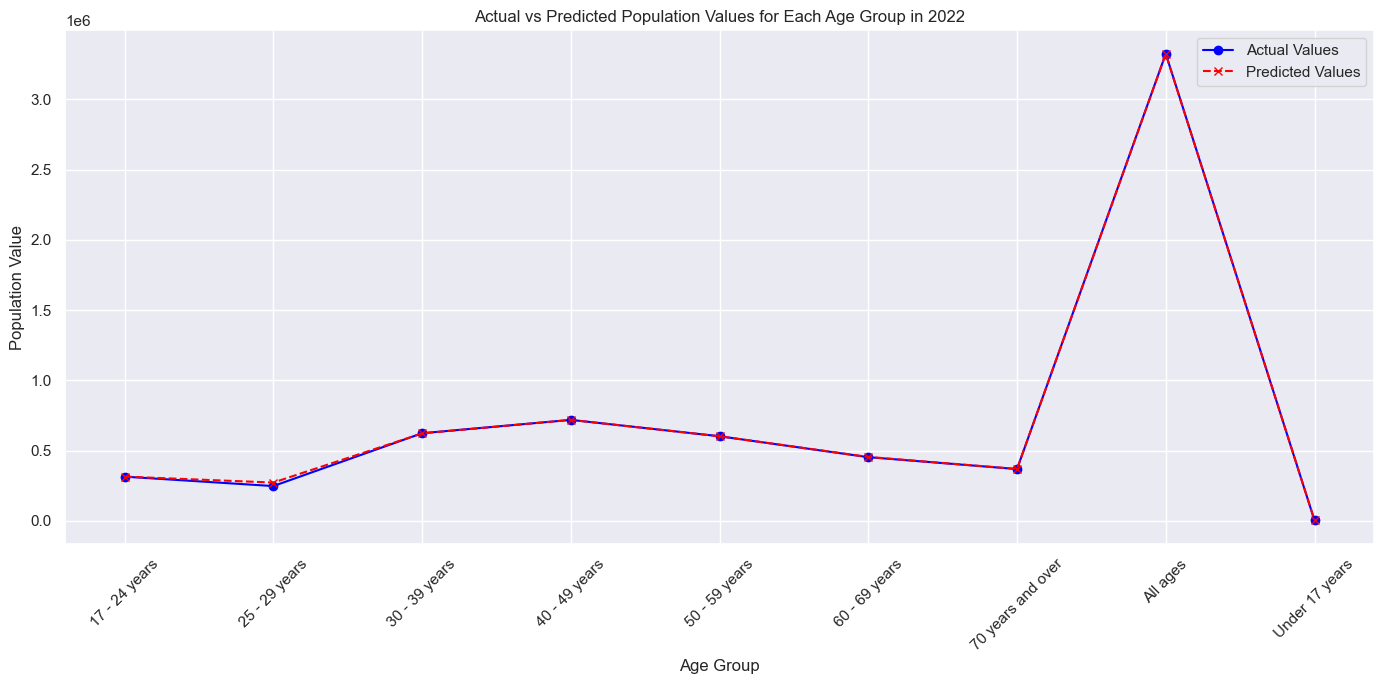

In [80]:
# Let's draw a graph for the year 2022, showing both actual data and model predictions.
# First, let's make predictions for the year 2022.
X_2022 = df_GBR[df_GBR["Year"] == 2022][["Year", "Age Group"]]
X_2022["Age Group Encoded"] = label_encoder.transform(X_2022["Age Group"])
y_2022_pred = best_gbr_model.predict(X_2022[["Year", "Age Group Encoded"]])

# Get the actual data for the year 2022.
y_2022_actual = df_GBR[df_GBR["Year"] == 2022]["Value"]

# Draw the graph.
plt.figure(figsize=(14, 7))
plt.plot(X_2022["Age Group"], y_2022_actual, label="Actual Values", color="blue", marker="o")
plt.plot(X_2022["Age Group"], y_2022_pred, label="Predicted Values", color="red", linestyle="--", marker="x")
plt.title("Actual vs Predicted Population Values for Each Age Group in 2022")
plt.xlabel("Age Group")
plt.ylabel("Population Value")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [81]:
# Creating a Dropdown widget
dropdown_GBR_age = widgets.Dropdown(
    options=df_GBR["Age Group"].unique(),
    description="Year:",
    disabled=False,
)

# Creating an output area to display the plot
output_GBR_age = widgets.Output()
def update_GBR_age(change):
    with output_GBR_age:
        clear_output(wait=True)  # Clear the current output
        selected_GBR_age = dropdown_GBR_age.value
        
        # Encode the selected age group using the label encoder
        selected_age_group_encoded = label_encoder.transform([selected_GBR_age])[0]
        years_GBR_age = df_GBR["Year"].unique()

        # Reconstruct the "all_predictions" DataFrame for the selected age group across all years
        all_predictions_df_GBR_age = []
        for year in years_GBR_age:
            year_array = np.full(shape=(1,), fill_value=year)
            age_group_encoded = label_encoder.transform([selected_GBR_age])
            predict_df_GBR_age = pd.DataFrame({
                "Year": year_array,
                "Age Group Encoded": age_group_encoded
            })
            predicted_value_GBR_age = best_gbr_model.predict(predict_df_GBR_age)
            true_value = df_GBR[(df_GBR["Year"] == year) & 
                                      (df_GBR["Age Group Encoded"] == selected_age_group_encoded)]["Value"].values
            # Use the predicted value if no actual value is present for that year
            true_value = true_value[0] if true_value.size > 0 else predicted_value_GBR_age[0]
            all_predictions_df_GBR_age.append((year, true_value, predicted_value_GBR_age[0]))

        # Create a DataFrame from the predictions to facilitate plotting
        predictions_df_GBR_age = pd.DataFrame(all_predictions_df_GBR_age,
                                              columns=["Year", "Actual Value", "Predicted Value GBR"])

        # Plot a bar chart comparing the actual and predicted values
        plt.figure(figsize=(14, 7))
        width = 0.35  # Bar width
        plt.bar(predictions_df_GBR_age["Year"] - width/2, predictions_df_GBR_age["Actual Value"], width,
                label="Actual Values", color="blue")
        plt.bar(predictions_df_GBR_age["Year"] + width/2, predictions_df_GBR_age["Predicted Value GBR"],
                width, label="Predicted Values GBR", color="green")

        plt.title(f"Actual vs Predicted Population Values for {selected_GBR_age} Over the Years")
        plt.xlabel("Year")
        plt.ylabel("Population Value GBR")
        plt.xticks(predictions_df_GBR_age["Year"], rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Set up observation for changes in the Dropdown widget to update the plot accordingly
dropdown_GBR_age.observe(update_GBR_age, names="value")

# Display the Dropdown widgets and the output area
display(dropdown_GBR_age, output_GBR_age)
update_GBR_age(None)  # Initial plot

Dropdown(description='Year:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years', '50…

Output()

## Compare 

In [82]:
# Creating a Dropdown widget
dropdown_df_age_compare = widgets.Dropdown(
    options=df_GBR["Age Group"].unique(),
    description="Year:",
    disabled=False,
)

# Creating an output area to display the plot
output_df_age_compare = widgets.Output()
def update_df_age_compare(change):
    with output_df_age_compare:
        clear_output(wait=True)  # Clear the current output
        selected_df_age_compare = dropdown_df_age_compare.value
        
        # Encode the selected age group using the label encoder
        selected_age_group_encoded = label_encoder.transform([selected_df_age_compare])[0]
        years_df_age_compare = df_GBR["Year"].unique()

        # Reconstruct the "all_predictions" DataFrame for the selected age group across all years
        all_predictions_df_GBR_age_compare = []
        for year in years_df_age_compare:
            year_array = np.full(shape=(1,), fill_value=year)
            age_group_encoded = label_encoder.transform([selected_df_age_compare])
            predict_df_GBR_age_compare = pd.DataFrame({
                "Year": year_array,
                "Age Group Encoded": age_group_encoded
            })
            predicted_value_df_GBR_age_compare = best_gbr_model.predict(predict_df_GBR_age_compare)
            true_value = df_GBR[(df_GBR["Year"] == year) & 
                                      (df_GBR["Age Group Encoded"] == selected_age_group_encoded)]["Value"].values
            # Use the predicted value if no actual value is present for that year
            true_value = true_value[0] if true_value.size > 0 else predicted_value_df_GBR_age_compare[0]
            all_predictions_df_GBR_age_compare.append((year, true_value, predicted_value_df_GBR_age_compare[0]))

        # Create a DataFrame from the predictions to facilitate plotting
        predictions_df_GBR_age_compare = pd.DataFrame(all_predictions_df_GBR_age_compare,
                                                      columns=["Year", "Actual Value", "Predicted Value GBR"])

        all_predictions_df_RFR_age_compare = []
        for year in years_df_age_compare:
            year_array = np.full(shape=(1,), fill_value=year)
            age_group_encoded = label_encoder.transform([selected_df_age_compare])
            predict_df_RFR_age_compare = pd.DataFrame({
                "Year": year_array,
                "Age Group Encoded": age_group_encoded
            })
            predicted_value_df_RFR_age_compare = best_rf_model.predict(predict_df_RFR_age_compare)
            all_predictions_df_RFR_age_compare.append((year, true_value, predicted_value_df_RFR_age_compare[0]))

        # Create a DataFrame from the predictions to facilitate plotting
        predictions_df_RFR_age_compare = pd.DataFrame(all_predictions_df_RFR_age_compare,
                                                      columns=["Year", "Actual Value", "Predicted Value RFR"])

        # Create a DataFrame from the predictions to facilitate plotting
        predictions_df_compare = predictions_df_GBR_age_compare.copy()
        predictions_df_compare["Predicted Value RFR"] = predictions_df_RFR_age_compare["Predicted Value RFR"].copy()

        # Plot a bar chart comparing the actual and predicted values
        plt.figure(figsize=(14, 7))
        width = 0.2  # Bar width
        plt.bar(predictions_df_compare["Year"] - width, predictions_df_compare["Actual Value"], width,
                label="Actual Values", color="blue")
        plt.bar(predictions_df_compare["Year"], predictions_df_compare["Predicted Value RFR"], width,
                label="Predicted Values RFR", color="red")
        plt.bar(predictions_df_compare["Year"] + width, predictions_df_compare["Predicted Value GBR"], width,
                label="Predicted Values GBR", color="green")
        plt.title(f'''Actual vs Predicted Values Random forest vs Gradient Boosting for 
                    {selected_df_age_compare} Over the Years''')
        plt.xlabel("Year")
        plt.ylabel("Population Value")
        plt.xticks(predictions_df_compare["Year"], rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Set up observation for changes in the Dropdown widget to update the plot accordingly
dropdown_df_age_compare.observe(update_df_age_compare, names='value')

# Display the Dropdown widgets and the output area
display(dropdown_df_age_compare, output_df_age_compare)
update_df_age_compare(None)  # Initial plot

Dropdown(description='Year:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years', '50…

Output()

## Sentiment Analysis

In [83]:
#comments_df2.to_csv("depressional.csv", index=False)
# with open("t1am4z.txt", "w", encoding="utf-8") as file:
#     for comment in comments_list:
#         file.write("%s\n\n" % comment)

In [84]:
import praw

reddit = praw.Reddit(
    client_id="bIYyUx9pkrIdPG1hfbZjAQ",             # My Reddit application's client ID
    client_secret="xJXIPO2MLhkciCEIkqnlzYDCXq6JtA", # My Reddit application's client secret
    user_agent="Current_Driving_Licences"           # My Reddit application's user agent 
)

#By what age do most people hope to get their drivers license?
submission_id = 't6055k'  # The submission's ID on Reddit
submission = reddit.submission(id=submission_id)

comments_list = []  # Initialize an empty list to store comments

# Resolve "MoreComments" placeholders and retrieve all comments from the submission
submission.comments.replace_more(limit=0)  
for comment in submission.comments.list(): # Iterate through the comments of the submission
    comments_list.append(comment.body)     # Append the content of each comment to the list
    #print(comments_list)

In [85]:
# Create a DataFrame from the comments list
comments_df = pd.DataFrame(comments_list, columns=["comment"])
#comments_df.to_csv("what_age.csv", index=False)
comments_df.head()

,comment
0,[deleted]
1,Learning to drive is expensive in Ireland and ...
2,I am 29 and am in the middle of my lessons now...
3,[deleted]
4,Whenever is convenient and they can afford to....


In the DataFrame, I then converted all text within the 'comment' column to lowercase to ensure uniformity across the dataset. This standardization is critical as it helps in treating the same words consistently, irrespective of their case in the original text.

Following that, I removed any special characters and extra spaces from the comments. Cleaning the text data in this manner is beneficial for the analysis as it reduces complexity and eliminates potential noise that could skew the sentiment analysis results.

Finally, I saved the cleaned data into a new DataFrame named cleared_comments_df. This practice of assigning the processed data to a new variable helps in preserving the original data, which can be useful for any subsequent operations that may require the data in its initial form.

### Cleaning DataFrame

In [86]:
# Copy the comment DataFrame into a new DataFrame for cleanning
cleared_comments_df = comments_df.copy()

# Filtering out the comments that contain the word "deleted"
cleared_comments_df = cleared_comments_df[cleared_comments_df["comment"] != "[deleted]"]
# Resetting the index of the DataFrame to account for the removed rows and to ensure that the index is continuous.
cleared_comments_df.reset_index(drop=True, inplace=True)

# Correcting the conversion of text to lowercase by rechecking
cleared_comments_df["comment"] = cleared_comments_df["comment"].str.lower()

# Cleaning special characters and excess spaces again
cleared_comments_df["comment"] = cleared_comments_df["comment"].str.replace(r"[^\w\s]", "", regex=True)
cleared_comments_df["comment"] = cleared_comments_df["comment"].str.replace(r"\s+", " ", regex=True)


# Checking the first five rows after Correcting
cleared_comments_df.head()

,comment
0,learning to drive is expensive in ireland and ...
1,i am 29 and am in the middle of my lessons now...
2,whenever is convenient and they can afford to ...
3,im nearly 34 started the process when i was 28...
4,im 29 and still cant afford lessons as im a pr...


With TextBlob, we can assess the polarity of sentiments, which gives us a numerical score indicating the emotional tone of the text.

I then defined a function named analyze_sentiment that applies TextBlob's sentiment analysis to any given text. This function returns a sentiment polarity score ranging from -1.0 to 1.0, where -1.0 indicates a strongly negative sentiment, 0 indicates neutrality, and 1.0 indicates a strongly positive sentiment.

Applying this function to each comment in the cleared_comments_df DataFrame, I calculated the sentiment scores and stored them in a new column called sentiment_score. This process effectively quantifies the sentiment of each comment, which is critical for understanding the overall sentiment distribution within the data.

In [87]:
from textblob import TextBlob

def analyze_sentiment(text):# Function to analyze the sentiment of a given text
    return TextBlob(text).sentiment.polarity 


# Applying sentiment analysis to get updated sentiment scores
cleared_comments_df["sentiment_score"] = cleared_comments_df["comment"].apply(analyze_sentiment)

# Get descriptive statistics of the updated sentiment scores
sentiment_statistics_updated = cleared_comments_df["sentiment_score"].describe()
sentiment_statistics_updated, 

(count    39.000000
 mean      0.051046
 std       0.239270
 min      -0.625000
 25%      -0.009097
 50%       0.050000
 75%       0.211688
 max       0.533333
 Name: sentiment_score, dtype: float64,)

- Count: 39 entries, which means sentiment scores have been calculated for 41 comments.
- Mean: Approximately 0.051, suggesting a slightly positive average sentiment across all comments.
- Standard Deviation: Approximately 0.239, indicating variability in the sentiment scores.
- Minimum: -0.625, showing that there is at least one comment with a strongly negative sentiment.
- 25%: The first quartile sentiment score is approximately -0.009, which means that 25% of the comments have this score or lower.
- 50% (Median): The median sentiment score is 0.050, suggesting a fairly neutral overall sentiment.
- 75%: The third quartile sentiment score is about 0.212, indicating that 75% of the comments have this score or lower.
- Maximum: The most positive sentiment score in the dataset is 0.533.

In [88]:
# Defining the sentiment categories based on sentiment scores
def categorize_sentiment(score):
    if score < 0:
        return "negative"
    elif score == 0:
        return "neutral"
    else:
        return "positive"

# Applying the categorization function to the sentiment scores
cleared_comments_df["sentiment_category"] = cleared_comments_df["sentiment_score"].apply(categorize_sentiment)

# Mapping the sentiment categories to numerical indices as per 'sentiment_ordering'
sentiment_ordering = ["negative", "neutral", "positive"]
cleared_comments_df["y"] = cleared_comments_df["sentiment_category"].apply(lambda x: sentiment_ordering.index(x))

cleared_comments_df.head(5)


,comment,sentiment_score,sentiment_category,y
0,learning to drive is expensive in ireland and ...,-0.166667,negative,0
1,i am 29 and am in the middle of my lessons now...,0.233333,positive,2
2,whenever is convenient and they can afford to ...,0.316667,positive,2
3,im nearly 34 started the process when i was 28...,-0.081818,negative,0
4,im 29 and still cant afford lessons as im a pr...,-0.333333,negative,0


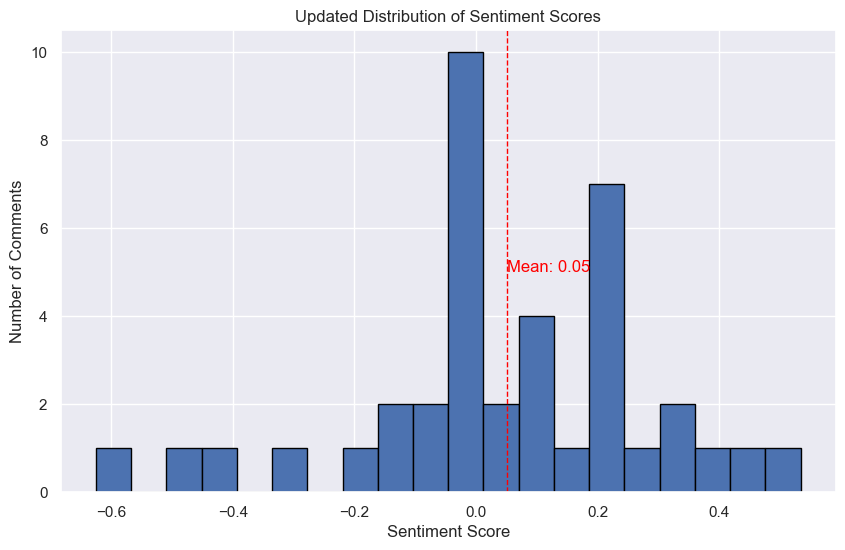

In [89]:
# Creating a histogram to visualize the distribution of the updated sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(cleared_comments_df["sentiment_score"], bins=20, edgecolor="black")
plt.title("Updated Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Comments")

# Draw a vertical line at the mean sentiment score
plt.axvline(cleared_comments_df["sentiment_score"].mean(), color="red", linestyle="dashed", linewidth=1)

# Annotate the mean value on the plot
plt.text(cleared_comments_df["sentiment_score"].mean(), 5,
         f"Mean: {cleared_comments_df['sentiment_score'].mean():.2f}", color="red")
plt.grid(True)
plt.show()

The histogram shows the sentiment scores of comments, with the majority centered around a slightly positive mean of 0.05, indicating a general lean towards positive sentiment. Despite this, there's a noticeable presence of negative sentiment in the data, suggesting a mix of opinions. The distribution of scores implies that while positive sentiments are more common, negative sentiments, where present, tend to be strongly expressed, thus affecting the overall average sentiment score.







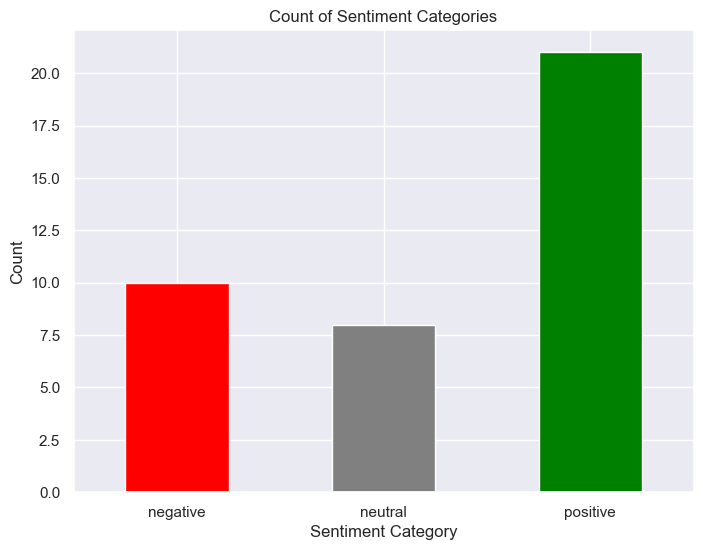

In [90]:
# Creating a bar chart to visualize the count of each sentiment category ("negative", "neutral", "positive")
sentiment_counts = cleared_comments_df["sentiment_category"].value_counts()
sentiment_counts = sentiment_counts.reindex(["negative", "neutral", "positive"])

# Creating the bar chart
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind="bar", color=["red", "grey", "green"])
plt.title("Count of Sentiment Categories")
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.xticks(rotation=0)  # Rotating the x labels so they show up as horizontal
plt.show()

The bar chart above illustrates the distribution of sentiments—negative, neutral, and positive—across the comments in the dataset. The sentiments have been categorized based on their calculated sentiment scores. Each category is represented by a distinct color: red for negative, gray for neutral, and green for positive sentiments.

From the chart, it's evident that the majority of comments fall into the 'positive' category, indicated by the green bar, which suggests that a significant portion of the comments have a positive sentiment. This prevalence of positive sentiment could imply general satisfaction or favorable opinions within the context of the comments.

On the other hand, the red bar representing 'negative' sentiments is noticeably shorter than the green bar, indicating a smaller proportion of comments with negative sentiments. This suggests fewer instances of dissatisfaction or adverse opinions.

Finally, the 'neutral' category, represented by the gray bar, has the fewest comments. This minimal presence of neutral sentiments could indicate that most comments tend to have a definitive sentiment, either positive or negative, rather than being neutral or indifferent.

Overall, the chart offers a clear visual summary of the sentiment tendencies in the dataset, highlighting a predominant lean towards positive sentiments, with fewer comments exhibiting negative or neutral emotions.

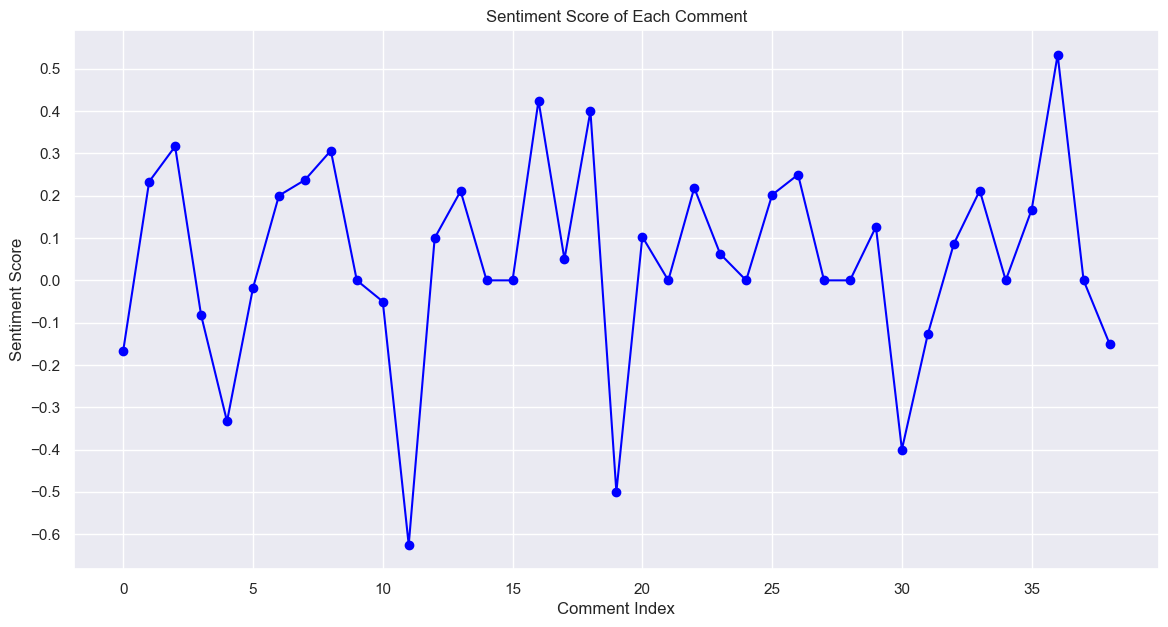

In [91]:
from matplotlib import ticker

# Creating a line plot for sentiment scores across comments
plt.figure(figsize=(14, 7))
plt.plot(cleared_comments_df.index, cleared_comments_df["sentiment_score"], marker="o", linestyle="-", color="blue")
# Set y-axis tick frequency using MultipleLocator.
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.10))  # This sets the interval of ticks to 0.10
plt.title("Sentiment Score of Each Comment")
plt.xlabel("Comment Index")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.show()

The line plot presents a clear depiction of the sentiment trajectory across a sequence of comments. Each point on the graph corresponds to a single comment's sentiment score, with the x-axis indicating the comment's position in the sequence and the y-axis representing the sentiment score derived from textual analysis. Notably, the plot shows a dynamic range of sentiment scores, from deeply negative (dipping as low as -0.6) to positively optimistic peaks (reaching up to 0.5). The sentiment scores exhibit considerable variation, suggesting that individual comments contain a diverse array of emotional expressions.



In [92]:
# Printing the minimum sentiment score
min_sentiment_score = cleared_comments_df["sentiment_score"].min()
print(f"sentiment_score: {min_sentiment_score:.3f}")

# Printing the comment for the first comment with the minimum sentiment score
print(f"Comment: {cleared_comments_df[cleared_comments_df['sentiment_score'] == min_sentiment_score]['comment'].iloc[0]}")

sentiment_score: -0.625
Comment: my nephew is 5 and is mad to get a license and go driving 


The sentiment analysis model assigned a negative score to the comment likely due to a lack of contextual understanding. In the phrase "mad to get a license," the word "mad" is colloquially used to mean eager or enthusiastic, which is positive. However, sentiment analysis tools like TextBlob might interpret "mad" as angry or insane, which are typically associated with negative sentiments. Without the ability to comprehend the full context in which words are used, the model can misinterpret the intended meaning and sentiment of the text. This limitation is particularly evident in models that rely on individual word sentiment without a robust understanding of phrase-level context or linguistic nuances.

In [93]:
# Printing the maximum sentiment score
min_sentiment_score = cleared_comments_df["sentiment_score"].max()
print(f"sentiment_score: {min_sentiment_score:.3f}")

# Printing the comment for the first comment with the maximum sentiment score
print(f"Comment: {cleared_comments_df[cleared_comments_df['sentiment_score'] == min_sentiment_score]['comment'].iloc[0]}")

sentiment_score: 0.533
Comment: yeah its not a well thought out system more about generating revenue than creating safe drivers it seems to be honest


The sentiment analysis model assigned a score of 0.53 to the comment, interpreting it as positive. This is likely due to the presence of words such as "well," "safe," and "honest," which are typically associated with positive sentiments. However, the actual context of the comment is critical. It criticizes the system, implying it is more focused on generating revenue than on ensuring the safety of drivers.
